# Modelo segmentación

***@versión - 2022***

***@author - Jazna Meza Hidalgo***

## Consideraciones

1. Se debe trabajar con un **archivo CSV** que contenga los resultados de la evaluación considerando los puntajes, de acuerdo a escala de valoración

2. La **cantidad de ítems**, dependerá de el detalle de la rúbrica asociada a la evaluación y debe ser definido.

3. La escala es la estándar que se maneja:

  + ED - Logro del aspecto en un 100%
  + AD - Logro del aspecto entre un 80% y un 99%
  + DA - Logro del aspecto entre un 60% y un 79%
  + DP - Logro del aspecto entre un 30% y un 59%
  + DC - Logro del aspecto inferior al 30%
  
  Cada uno de estos valores se escala de 1 a 5 

4. El archivo CSV de contar con las columnas OBLIGATORIAS:

  + ID del estudiante 
  + $I_{i}$ considerando cada ítem evaluado 

5. Considerando el archivo CSV se calculan 2 columnas: ***nota y categoría***.

6. Cálculo de la nota (en base al puntaje)

> $
nota(p) =
\begin{cases}
(n_{apr}-n_{min}) \cdot \dfrac{p}{e\cdot p_{max}} + n_{min}\text{ si } p<e\cdot p_{max} \\
\\
\\
\\
(n_{max}-n_{apr}) \cdot \dfrac{p-e\cdot p_{max}}{p_{max}\cdot(1-e)} + n_{apr} \text{    si } p \ge e\cdot p_{max}
\end{cases}
$

donde:
>+ $n_{max}$ = nota máxima
>+ $n_{min}$ = nota mínima
>+ $n_{min}$ = nota mínima
>+ $e$ = Exigencia 
>+ $p_{max}$ = puntaje máximo
>+ $p_{min}$ = puntaje mínimo
>+ $n_{aprob}$ = nota aprobación

7. Cálculo de la **categoría** se usa la función:


> $
categoria(nota)= \left\{ \begin{array}{lcc}
             1 & si  & nota \geq 6.0 \\            
             \\ 2 & si & 5.0 \leq nota \leq 5.9\\
             \\ 3 & si & 4.0 \leq nota \leq 4.9\\
             \\ 4 & si & 3.0 \leq nota \leq 3.9\\
             \\ 5 & si & nota \leq 2.9
             \end{array}
   \right.
$



8. Los candidatos a tutoría serán aquellos que estén en la **categoría 4 o 5**

## Carga de librerías

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, StandardScaler

from sklearn.metrics import silhouette_score, silhouette_samples

from sklearn.decomposition import PCA

import matplotlib.cm as cm
from sklearn.datasets import make_blobs
from scipy.stats import norm

import os

## Obtención de fuentes datos

In [2]:
CURRENT_DIR = os.getcwd() # Retrieve current directory
DATA_DIR = os.path.join(CURRENT_DIR, "data") 
if not os.path.isdir(DATA_DIR):
  os.mkdir(os.path.join(CURRENT_DIR, "data"))
os.chdir(DATA_DIR)
!pwd

/content/data


In [3]:
!wget https://www.dropbox.com/s/3rgq7lu6hivjnue/Simulation_data.csv
!wget https://www.dropbox.com/s/tupkzbyxedh2q29/Simulate_Data_01.csv
!ls

--2022-02-15 00:46:57--  https://www.dropbox.com/s/3rgq7lu6hivjnue/Simulation_data.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/3rgq7lu6hivjnue/Simulation_data.csv [following]
--2022-02-15 00:46:58--  https://www.dropbox.com/s/raw/3rgq7lu6hivjnue/Simulation_data.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc92e9e610f6b580c164bc5eb5ad.dl.dropboxusercontent.com/cd/0/inline/BfteHRJW457SX_eEeX_Ze5Oc3L-A_twAKHSdQRU2WQ1ZpB2I6mLC9KTOPz3HZc9sz-v7KdV8p9tAQRd-ZWYER32WNTd-M7U0ORSPVNVNbw0gkxlwmcr8f9JLF1wvczzCTExqbZenVR52Vy9q0jUIwOsY/file# [following]
--2022-02-15 00:46:58--  https://uc92e9e610f6b580c164bc5eb5ad.dl.dropboxusercontent.com/cd/0/inline/BfteHRJW457SX_eEeX_Ze5Oc3L-A_twAKHSdQRU2WQ1ZpB2I6mLC9KTOPz3HZc9sz-v7K

## Generación de datos aleatorios para pruebas

In [6]:
# Estas variables deben estar en el archivo de configuración
MAX_ESCALA = 5
N_ITEMS = 8
N_OBSERVACIONES = 150
N_CLUSTERS = 5
PUNTAJE = 7
PUNTAJE_MAXIMO = MAX_ESCALA*N_ITEMS
EXIGENCIA = 0.6
NOTA_MAXIMA = 7
NOTA_MINIMA = 1
NOTA_APROBACION = 4
PUNTAJE_CORTE = PUNTAJE_MAXIMO*EXIGENCIA

In [15]:
def generate_data(n_observaciones, n_items, n_clusters):
  """
  Genera la data completamente aleatorizada usando la librería sklearn
  """
  X, y = make_blobs(
        n_samples    = n_observaciones , 
        n_features   = n_items, 
        centers = n_clusters,
        cluster_std = 0.6,
        shuffle      = True, 
        random_state = 0
       )
  return X,y

def calculate_grade(puntaje):
    """
    Calcula la nota de acuerdo a la fórmula definida
    """
    if puntaje >= PUNTAJE_CORTE:
        nota = round((NOTA_MAXIMA - NOTA_APROBACION)*(puntaje-PUNTAJE_CORTE)/(PUNTAJE_MAXIMO*(1-EXIGENCIA))+NOTA_APROBACION,1)
    else: 
        nota = round((NOTA_APROBACION - NOTA_MINIMA)*(puntaje/PUNTAJE_CORTE)+NOTA_MINIMA,1)
    return nota

def calculate_category(nota):
    """
    Calcula la categoría de acuerdo a lo definido en los requerimientos
    """
    if nota >= 6.0: categoria = 1
    elif nota >= 5: categoria = 2
    elif nota >= 4: categoria = 3
    elif nota >= 3: categoria = 4
    else: categoria = 5
    return categoria

def generate_headers_items(n_items):
  """
  Genera las cabeceras de los ítems de evaluación de acuerdo a lo que exige el modelo
  """
  items_features = []
  for n_item in range(1, n_items + 1):
    items_features.append('i' + str(n_item))
  return items_features

def generate_headers(n_items):
  """
  Genera las cabezeras que debe tener la data de acuerdo a lo que exige el modelo
  """
  all_features = ['id']
  items_features = generate_headers_items(n_items)
  for n_item in range(1, n_items + 1):
    all_features.append('i' + str(n_item))
  all_features = all_features + ['puntaje','nota','categoria']
  return all_features, items_features

def calculate_save_from_random(n_observaciones, n_items, n_clusters, file_name = "Simulation_Data.csv"):
  """
  Genera un archivo CSV con datos completamente aleatorios usando la librería de sklearn
  """
  X, y = generate_data(n_observaciones, n_items, n_clusters)
  all_features, items_features = generate_headers(n_items)
  data_frame = pd.DataFrame(X, columns=items_features)
  data_frame = data_frame.apply(lambda value : round(abs(value)), axis = 1)
  for column in data_frame.columns:
    data_frame[column] = data_frame[column].apply(lambda value : np.max([value, 1.0]))
    data_frame[column] = data_frame[column].apply(lambda value : np.min([value, MAX_ESCALA]))
  data_frame['puntaje'] = data_frame.sum(axis=1)
  data_frame['nota'] = data_frame['puntaje'].apply(lambda row : calculate_grade(row))
  data_frame['categoria'] = data_frame['nota'].apply(lambda row : calculate_category(row))
  data_frame['id'] = range(1, X.shape[0]+1)
  data_frame = data_frame.reindex(columns=all_features)
  data_frame.to_csv(file_name, index = False)
  return data_frame  

def calculate_columns(data_frame, n_items):
  """
  Calcula las columnas puntaje y nota de acuerdo a lo que exige el modelo
  """
  all_features, items_features = generate_headers(n_items)
  X = data_frame[items_features]
  data_frame = data_frame.apply(lambda value : round(abs(value)), axis = 1)
  for column in data_frame.columns:
    data_frame[column] = data_frame[column].apply(lambda value : np.max([value, 1.0]))
    data_frame[column] = data_frame[column].apply(lambda value : np.min([value, MAX_ESCALA]))
  data_frame['puntaje'] = data_frame.sum(axis=1)
  data_frame['nota'] = data_frame['puntaje'].apply(lambda row : calculate_grade(row))
  data_frame['categoria'] = data_frame['nota'].apply(lambda row : calculate_category(row))
  data_frame['id'] = range(1, X.shape[0]+1)
  data_frame = data_frame.reindex(columns=all_features)
  return data_frame   

def validate_CSV(data, n_items):
  """
  Valida que el archivo venga con el estándar pedido
  """
  items_features = generate_headers_items(n_items)  
  return (list(data.columns) == list(['id'] + items_features))

def load_data(file_name):
  """
  Carga un archivo CSV y estandariza las nombres de las columnas 
  """
  data_frame = pd.read_csv(file_name) 
  # Estandarización de nombre de columnas
  data_frame.columns = data_frame.columns.str.lower().str.replace(" ", "", regex=False)
  data_frame.columns = data_frame.columns.str.lower().str.replace(".", "_", regex=False)  
  return data_frame  

In [18]:
# Genera data aleatoria de acuerdo al estándar con el cual quedará el CSV
data_frame = calculate_save_from_random(N_OBSERVACIONES, N_ITEMS, N_CLUSTERS)
data_frame

,id,i1,i2,i3,i4,i5,i6,i7,i8,puntaje,nota,categoria
0,1,1.0,4.0,2.0,2.0,2.0,3.0,2.0,5.0,21.0,3.6,4
1,2,1.0,4.0,2.0,1.0,2.0,3.0,2.0,5.0,20.0,3.5,4
2,3,1.0,1.0,5.0,3.0,2.0,2.0,5.0,3.0,22.0,3.8,4
3,4,5.0,3.0,5.0,5.0,1.0,2.0,5.0,5.0,31.0,5.3,2
4,5,1.0,1.0,5.0,2.0,3.0,3.0,5.0,3.0,23.0,3.9,4
...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,5.0,5.0,5.0,5.0,5.0,5.0,1.0,5.0,36.0,6.2,1
146,147,1.0,2.0,5.0,3.0,3.0,3.0,5.0,4.0,26.0,4.4,3
147,148,1.0,4.0,2.0,1.0,2.0,3.0,1.0,5.0,19.0,3.4,4
148,149,5.0,3.0,5.0,5.0,1.0,2.0,5.0,5.0,31.0,5.3,2


## Cálculo de columnas derivadas

En caso de que la carga de los datos sea una fuente externa

In [16]:
file_name = "Simulate_Data_01.csv"
initial_data = load_data(file_name)
if validate_CSV(initial_data, 8) == True:
  data_frame = calculate_columns(initial_data, N_ITEMS)
  print('Archivo CSV CORRECTO!!!')
else:
  print('Archivo CSV, no cumple con estándar')

Archivo CSV CORRECTO!!!


In [17]:
data_frame

,id,i1,i2,i3,i4,i5,i6,i7,i8,puntaje,nota,categoria
0,1,2.0,2.0,4.0,3.0,1.0,3.0,5.0,3.0,24.0,4.0,3
1,2,5.0,4.0,1.0,4.0,2.0,5.0,5.0,4.0,32.0,5.5,2
2,3,5.0,3.0,5.0,4.0,1.0,2.0,5.0,3.0,31.0,5.3,2
3,4,5.0,2.0,1.0,3.0,3.0,4.0,5.0,5.0,32.0,5.5,2
4,5,2.0,4.0,3.0,2.0,5.0,2.0,3.0,5.0,31.0,5.3,2
...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,2.0,1.0,1.0,4.0,5.0,5.0,3.0,1.0,27.0,4.6,3
146,147,3.0,3.0,1.0,3.0,2.0,1.0,4.0,2.0,24.0,4.0,3
147,148,3.0,5.0,5.0,4.0,3.0,4.0,2.0,5.0,36.0,6.2,1
148,149,2.0,1.0,3.0,1.0,1.0,3.0,5.0,3.0,24.0,4.0,3


## Análisis exploratorio

In [19]:
def view_histogram(data_frame, n_items, title):
  lst_feature = []
  for n_item in range(1, n_items + 1):
    lst_feature.append('i' + str(n_item))
  fig, ax = plt.subplots(2, 4, figsize=(20, 10))
  fig.suptitle(title, fontsize=28)
  row, col = 0, 0
  for feature in lst_feature:  
    sns.histplot(data_frame[feature], ax=ax[row][col], kde=True) 
    col += 1
    row += 0 if col < 4 else 1
    col = 0 if col > 3 else col
  plt.show()

def view_histogram_by_column(data_frame, column, title):
  try:
    sns.set(style='whitegrid')
    f, ax = plt.subplots(1,1, figsize=(12, 8))
    ax = sns.histplot(data_frame[column], kde = True, color = 'c')
    plt.title(title, fontsize = 28)
    plt.xlabel(column)
    plt.ylabel("Densidad")
    plt.show();
  except KeyError:
    print("Problema para visualizar gráfico")  

def count_by_column(data_frame, column):
  return data_frame.groupby(column).size()

def view_outliers(data_frame, column, title):
  ax = sns.boxplot(y=column, data=data_frame)
  plt.suptitle(title);  

def view_items(data_selected, n_items, title):
  lst_feature = []
  for n_item in range(1, n_items + 1):
    lst_feature.append('i' + str(n_item))
  fig, ax = plt.subplots(2, 4, figsize=(20, 10))
  fig.suptitle(title, fontsize=28)
  row, col = 0, 0
  for feature in lst_feature:  
    sns.boxplot(y=data_selected[feature], ax=ax[row][col], data=data_selected, color="r")
    col += 1
    row += 0 if col < 4 else 1
    col = 0 if col > 3 else col
  plt.show()  

def view_distribution(data_frame, hue, features):
  sns.pairplot(data_frame, hue=hue, height=4, vars=features, kind='scatter');

### Revisión de distribuciones

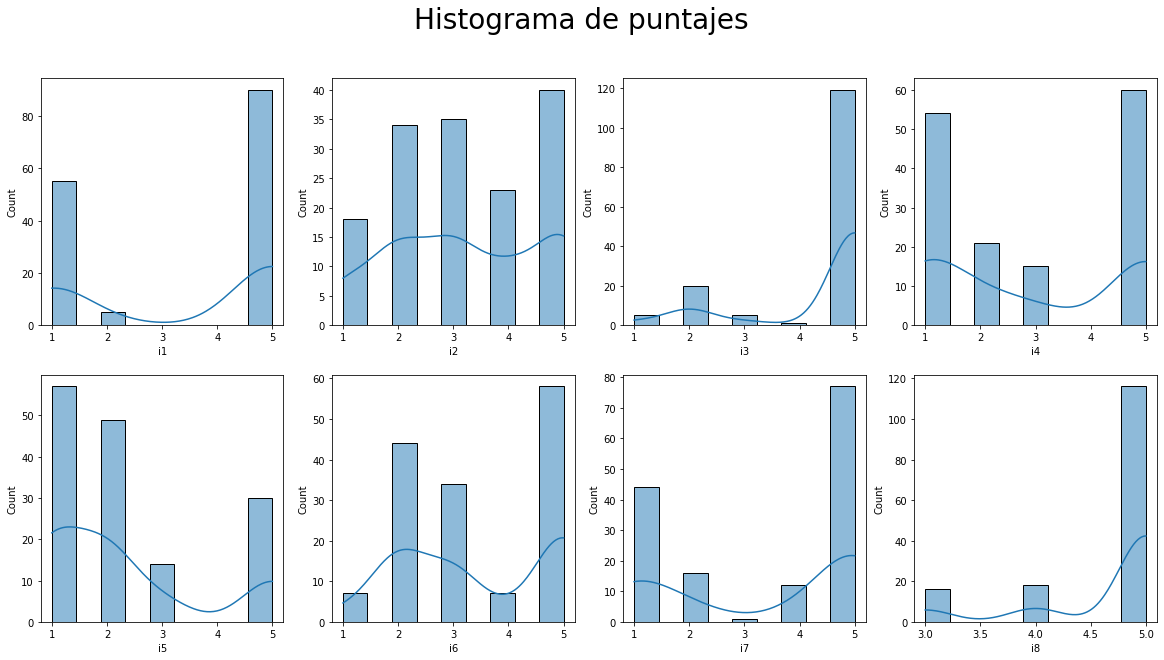

In [20]:
view_histogram(data_frame, N_ITEMS, "Histograma de puntajes")

In [21]:
selected = data_frame.columns.difference(['id', 'categoria'])
data_frame[selected].describe()

,i1,i2,i3,i4,i5,i6,i7,i8,nota,puntaje
count,150.000000,150.00000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,3.433333,3.22000,4.393333,2.940000,2.313333,3.433333,3.413333,4.666667,4.771333,27.813333
std,1.933167,1.37509,1.231012,1.788216,1.479782,1.377756,1.806724,0.662177,1.003038,5.936336
min,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.100000,17.000000
25%,1.000000,2.00000,5.000000,1.000000,1.000000,2.000000,1.000000,5.000000,3.825000,22.250000
50%,5.000000,3.00000,5.000000,2.500000,2.000000,3.000000,5.000000,5.000000,5.100000,30.000000
75%,5.000000,5.00000,5.000000,5.000000,3.000000,5.000000,5.000000,5.000000,5.300000,31.000000
max,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.400000,37.000000


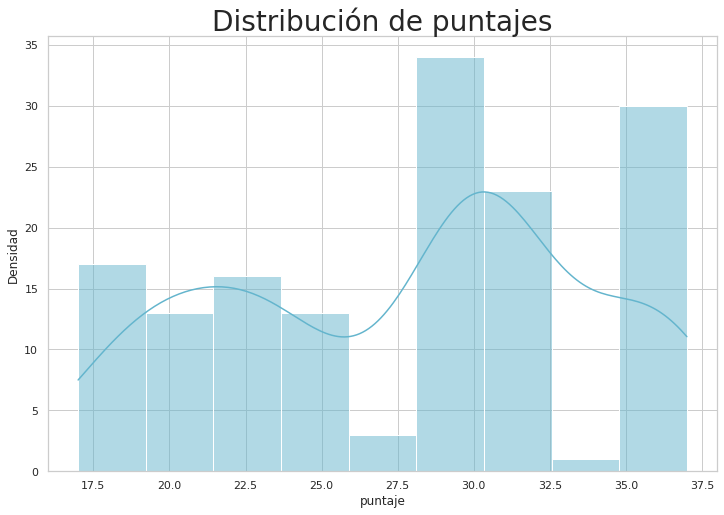

In [22]:
view_histogram_by_column(data_frame,'puntaje', 'Distribución de puntajes')

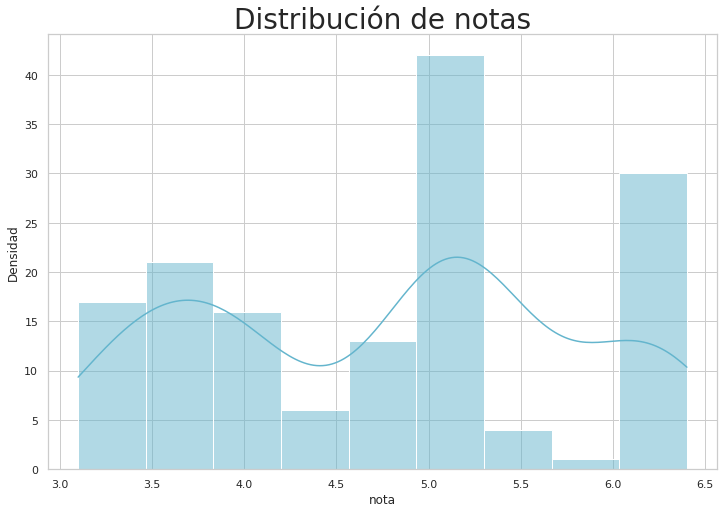

In [23]:
view_histogram_by_column(data_frame,'nota','Distribución de notas')

In [24]:
print(count_by_column(data_frame, "categoria"))

categoria
1    30
2    47
3    27
4    46
dtype: int64


### Revisando outliers

In [25]:
def get_norm_gaussian(data_frame, column):
  return norm.fit(data_frame[column])

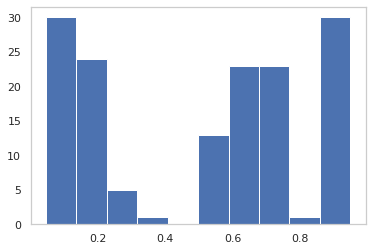

In [26]:
params = get_norm_gaussian(data_frame, 'nota')
data_frame['prob_total'] = [norm(params[0], params[1]).cdf(x) for x in data_frame.nota]
data_frame.prob_total.hist(grid=False);

In [40]:
data_frame[data_frame['prob_total'] > 0.95]

,id,i1,i2,i3,i4,i5,i6,i7,i8,puntaje,nota,categoria,prob_total
8,9,5.0,5.0,5.0,4.0,4.0,2.0,4.0,3.0,37.0,6.4,1,0.963266
13,14,4.0,4.0,4.0,5.0,1.0,5.0,5.0,4.0,37.0,6.4,1,0.963266
40,41,5.0,5.0,2.0,3.0,4.0,5.0,5.0,4.0,38.0,6.6,1,0.979865
49,50,4.0,5.0,4.0,3.0,5.0,2.0,5.0,4.0,37.0,6.4,1,0.963266
79,80,4.0,4.0,5.0,3.0,5.0,5.0,2.0,5.0,38.0,6.6,1,0.979865
132,133,4.0,4.0,5.0,2.0,4.0,5.0,3.0,5.0,37.0,6.4,1,0.963266


In [34]:
data_frame[data_frame['prob_total'] < 0.05]

,id,i1,i2,i3,i4,i5,i6,i7,i8,puntaje,nota,categoria,prob_total
36,37,1.0,1.0,3.0,3.0,2.0,3.0,2.0,1.0,21.0,3.6,4,0.031108
44,45,2.0,1.0,2.0,3.0,1.0,5.0,1.0,1.0,21.0,3.6,4,0.031108
64,65,5.0,4.0,1.0,1.0,1.0,2.0,1.0,1.0,21.0,3.6,4,0.031108
70,71,1.0,2.0,2.0,2.0,1.0,2.0,3.0,2.0,20.0,3.5,4,0.023007
77,78,1.0,2.0,1.0,1.0,4.0,3.0,3.0,1.0,21.0,3.6,4,0.031108
80,81,1.0,3.0,1.0,1.0,3.0,1.0,1.0,3.0,19.0,3.4,4,0.016760
95,96,1.0,1.0,3.0,2.0,3.0,1.0,1.0,1.0,18.0,3.2,4,0.008497
139,140,2.0,2.0,1.0,2.0,1.0,3.0,1.0,2.0,19.0,3.4,4,0.016760


## Selección de candidatos a tutoría

In [50]:
def get_selected(data_frame, column, limit):
  str_query = "{0} >= {1}".format(column, limit) 
  return data_frame.query(str_query)

In [51]:
#data_selected = data_frame.query("categoria >= 4")
data_selected = get_selected(data_frame, "categoria", 4)
data_selected.shape

(13, 13)

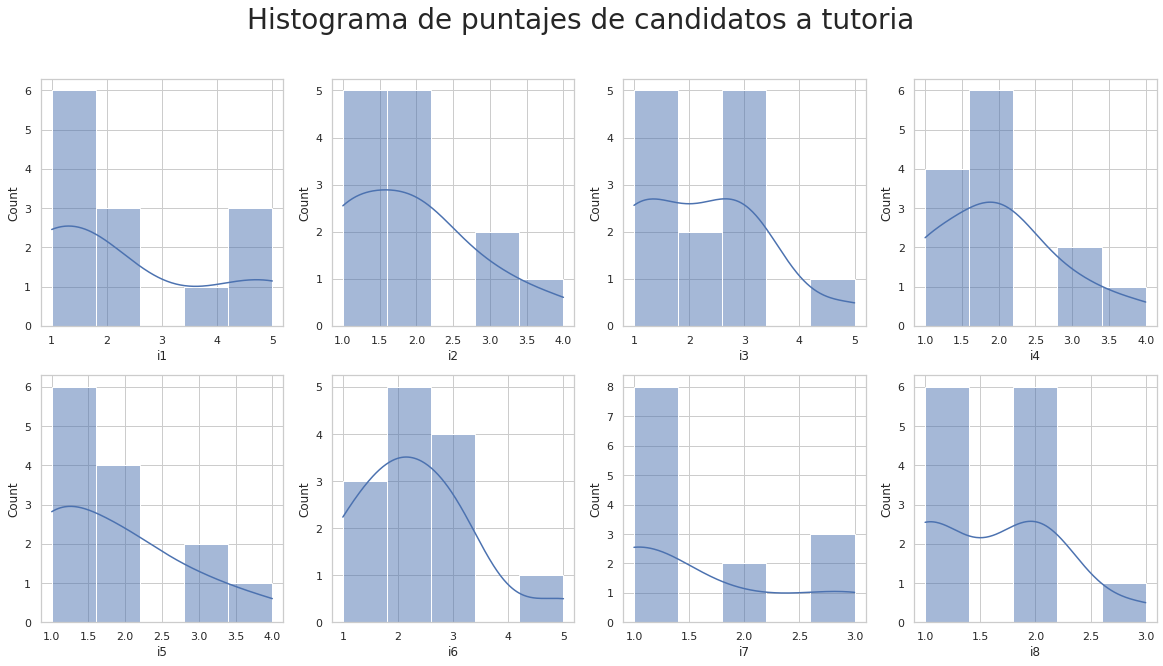

In [58]:
view_histogram(data_selected, N_ITEMS, "Histograma de puntajes de candidatos a tutoria")

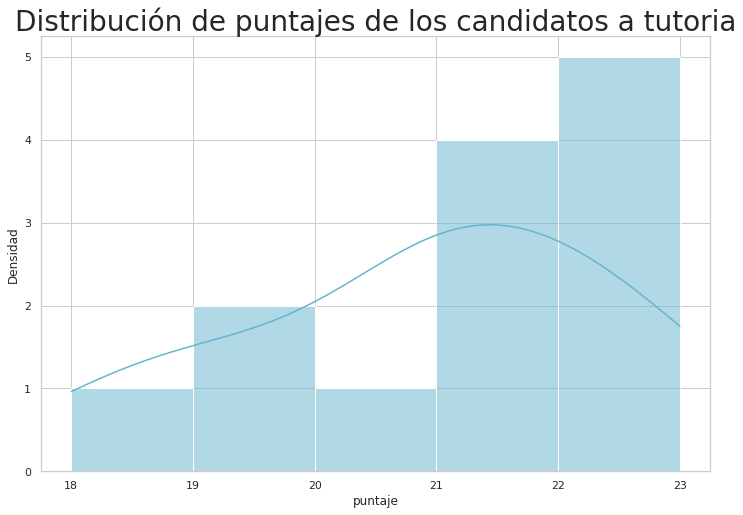

In [59]:
view_histogram_by_column(data_selected,'puntaje','Distribución de puntajes de los candidatos a tutoria')

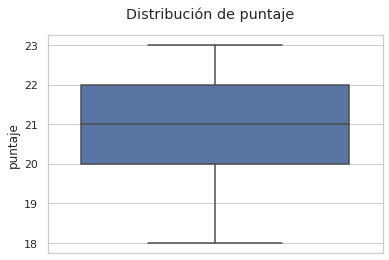

In [119]:
# Revisión de outliers
view_outliers(data_selected, 'puntaje', "Distribución de puntaje")

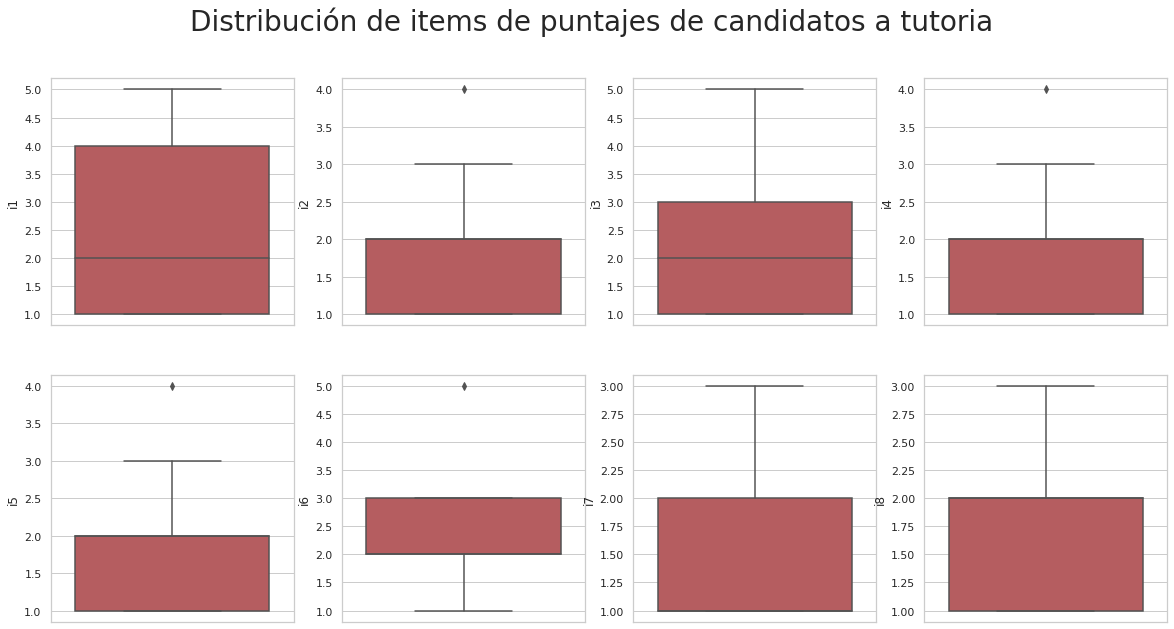

In [60]:
view_items(data_selected, N_ITEMS,  "Distribución de items de puntajes de candidatos a tutoria")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


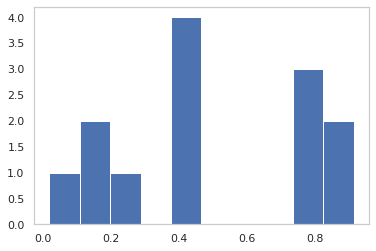

In [61]:
params = get_norm_gaussian(data_selected, 'nota')
data_selected['prob_total'] = [norm(params[0], params[1]).cdf(x) for x in data_selected.nota]
data_selected.prob_total.hist(grid=False);

In [62]:
pd.cut(data_selected.nota, bins=[1.0,2.0,3.0,4.0]).value_counts()

(3.0, 4.0]    13
(1.0, 2.0]     0
(2.0, 3.0]     0
Name: nota, dtype: int64

In [63]:
data_selected.groupby('categoria')[['puntaje','nota']].describe()

puntaje                                 ... nota                    
            count       mean     std   min   25%  ...  min  25%  50%  75%  max
categoria                                         ...                         
4            13.0  20.923077  1.5525  18.0  20.0  ...  3.2  3.5  3.6  3.8  3.9

[1 rows x 16 columns]

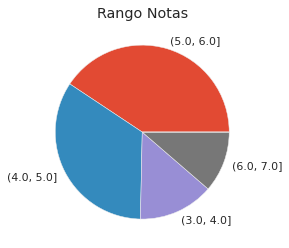

In [64]:
data = pd.cut(data_frame.nota, bins=[1.0,2.0,3.0,4.0,5.0,6.0,7.0]).value_counts()
plt.axis("off")
plt.style.use('ggplot')
data.plot(kind="pie", title="Rango Notas");
plt.style.use('default')

#data.plot(kind="bar",stacked=True, rot=45);
#plot = data_frame.plot.pie(subplots=True, figsize=(11, 6))

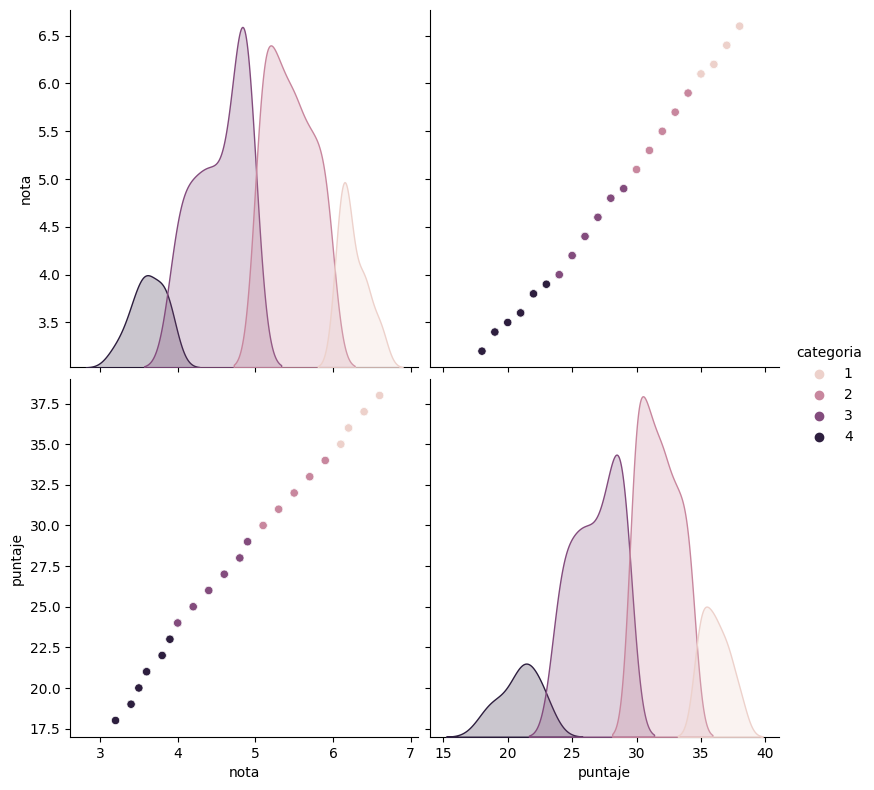

In [65]:
view_distribution(data_frame, 'categoria', ['nota', 'puntaje'])

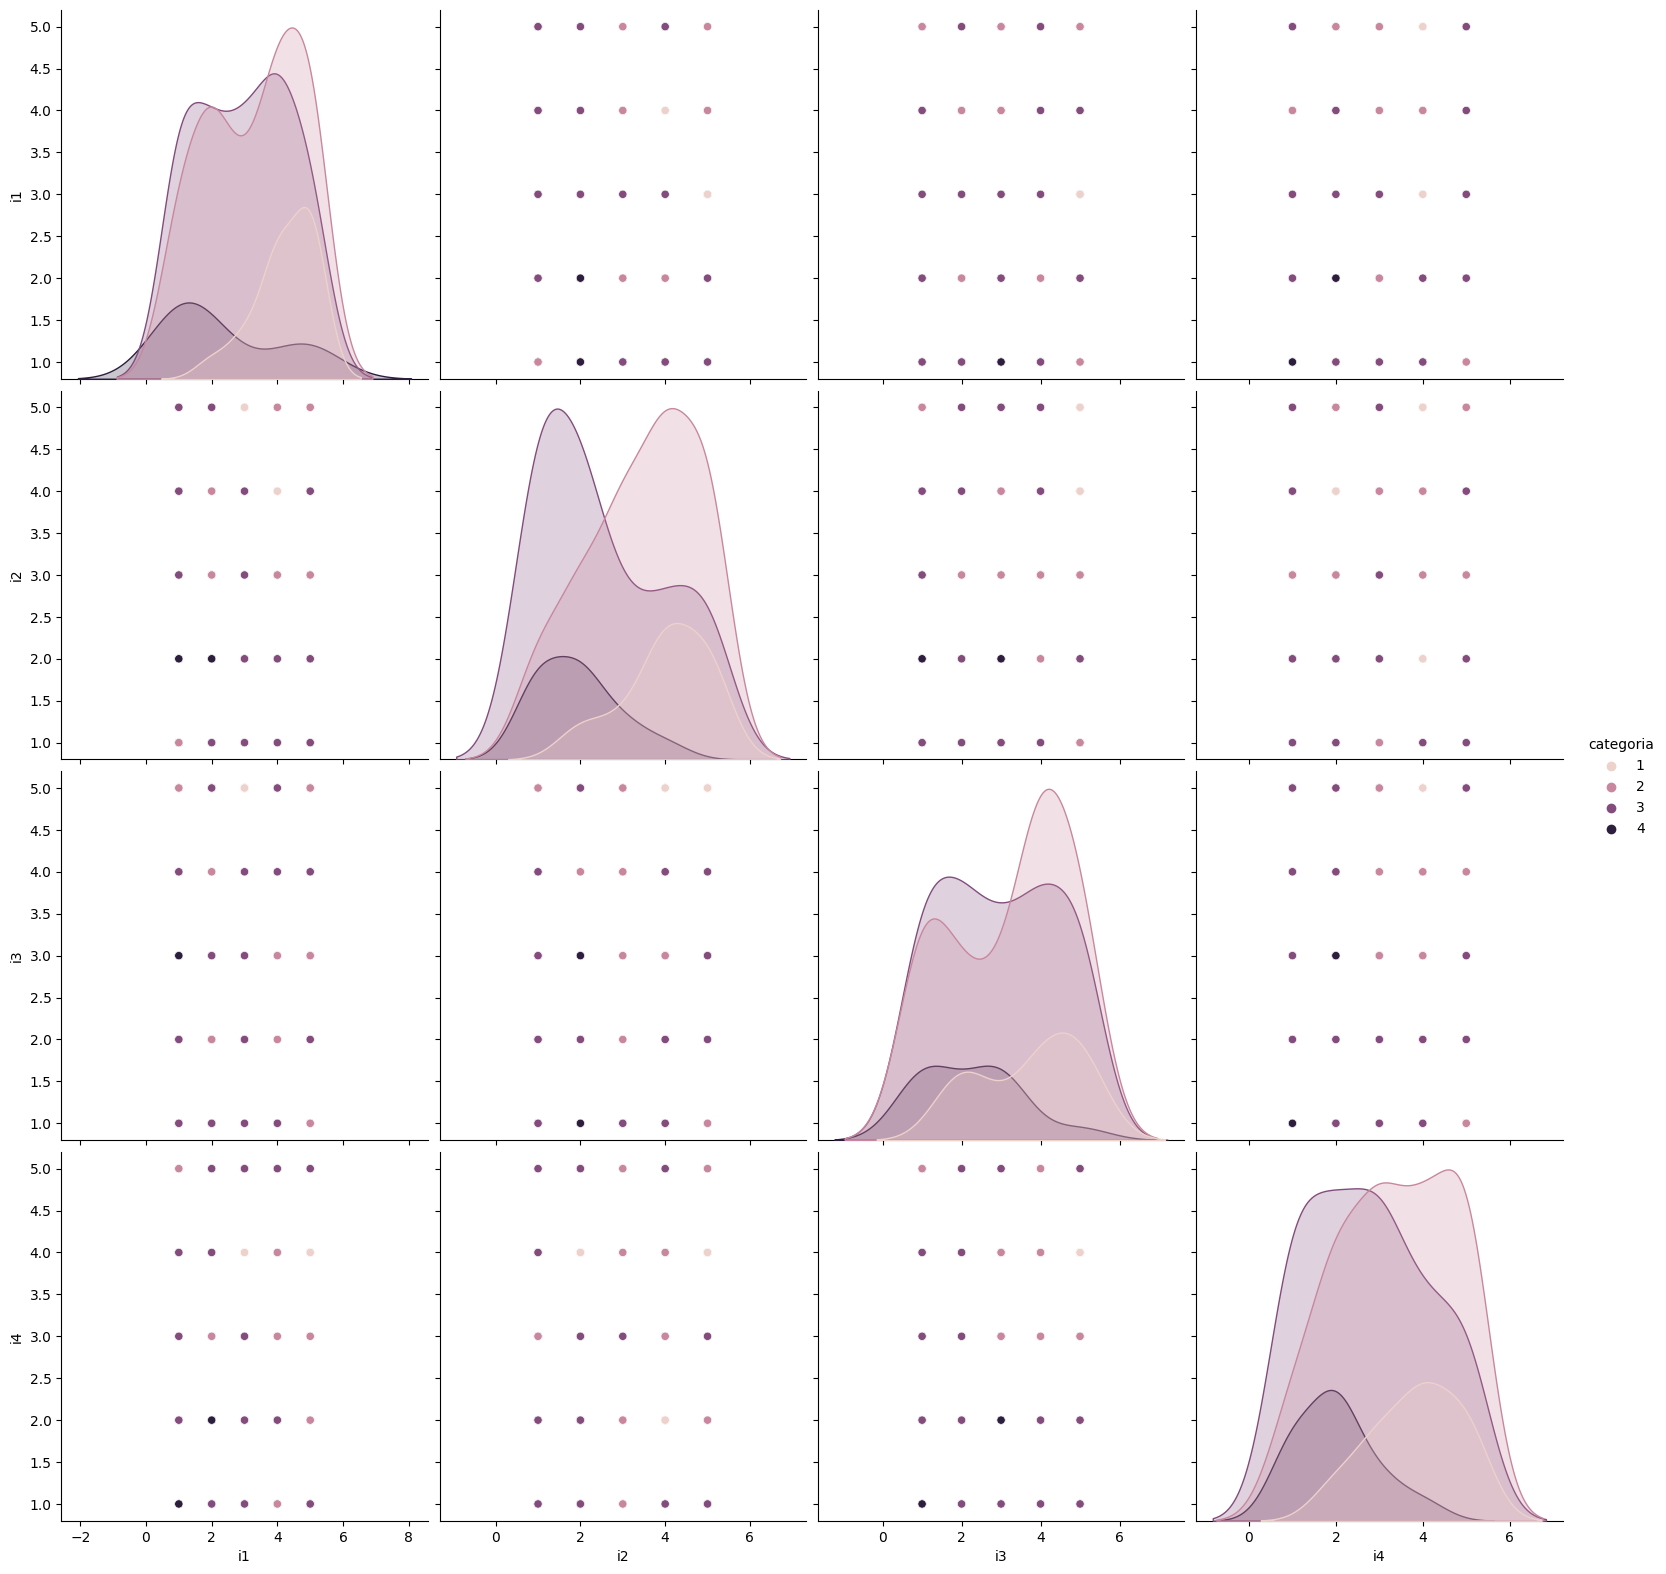

In [154]:
view_distribution(data_frame, 'categoria', ['i1', 'i2', 'i3','i4'])

## Escalado de los datos

In [69]:
def scale_data(data_selected, n_items):
  items_features = []
  for n_item in range(1, n_items + 1):
    items_features.append('i' + str(n_item))  
  exclude = data_selected.columns.difference(items_features)
  X_features = np.array(data_selected[data_selected.columns.drop(exclude)])  
  scaler = StandardScaler()
  X_features_scaled = scaler.fit_transform(X_features)
  return X_features_scaled

In [70]:
X_features_scaled = scale_data(data_selected, N_ITEMS)

In [71]:
print(X_features_scaled.shape)

(13, 8)


## Reducción de la dimensionalidad

El $\textbf{método de componentes principales}$ se usa para explicar la estructura de varianza-covarianzas de una muestra a partir
de unas pocas combinaciones lineales de las variables originales, denominadas $\textit{componentes principales}$

In [153]:
def plotting_variances(X_features_scaled):
  # Plotting the variances for each PC
  pca = PCA()
  principal_components = pca.fit_transform(X_features_scaled)
  PC = range(1, pca.n_components_+1)
  plt.bar(PC, pca.explained_variance_ratio_, color='blue')
  plt.xlabel('Componentes principales')
  plt.ylabel('Varianza %')
  plt.xticks(PC)
  plt.title("Varianza utilizando varios componentes", fontsize=18)

  # Putting components in a dataframe for later
  PCA_components = pd.DataFrame(principal_components)
  return PCA_components

def cluster_by_PCA(n_pca, PCA_components, max_clusters = 10, kmeans_init = None):
  p_init = 'k-means++' if kmeans_init is None else kmeans_init
  inertias = []

  # Creating 10 K-Mean models while varying the number of clusters (k)
  for k in range(2,max_clusters + 1):
    model = KMeans(n_clusters=k,  init = p_init, random_state = 29)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:n_pca])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
  plt.plot(range(2,max_clusters+1), inertias, '-p', color='red')
  plt.xlabel('Número de cluster, k')
  plt.ylabel('inercia')
  plt.title('Variación de inercias usando PCA {0} y K-MEANS {1}'.format(n_pca, p_init))
  plt.show()  

def group_by_PCA(n_PCA, PCA_components, n_clusters, kmeans_init = None):
  kmeans_init = 'k-means++' if kmeans_init is None else kmeans_init
  model = KMeans(n_clusters=n_clusters, init = kmeans_init, random_state = 29)
  model.fit(PCA_components.iloc[:,:n_PCA])
  fig, ax = plt.subplots(figsize=(8,8))
  labels = model.predict(PCA_components.iloc[:,:n_PCA])
  scatter = ax.scatter(PCA_components[0], PCA_components[1], c=labels, cmap="Dark2_r", s=100, alpha=0.9)
  legend1 = ax.legend(*scatter.legend_elements(),
                    loc="best", title="Grupos")
  ax.add_artist(legend1)
  plt.title("Agrupación con reducción dimensional con K-MEANS {}".format(kmeans_init),fontsize=28)
  plt.show()
  return labels

def get_data_final(data_selected, labels):
  data_final = data_selected.copy()
  data_final['grupo'] = labels
  return data_final  

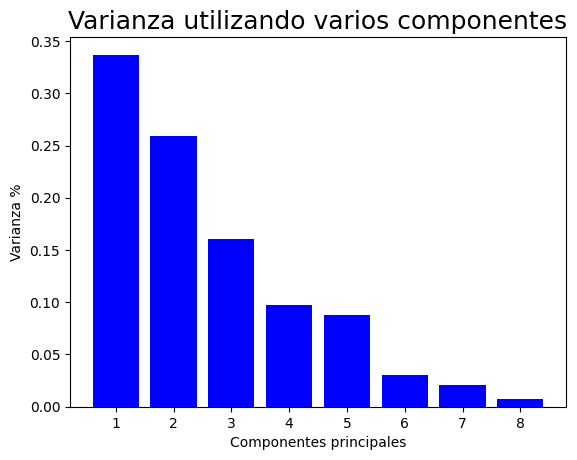

In [96]:
PCA_components = plotting_variances(X_features_scaled)

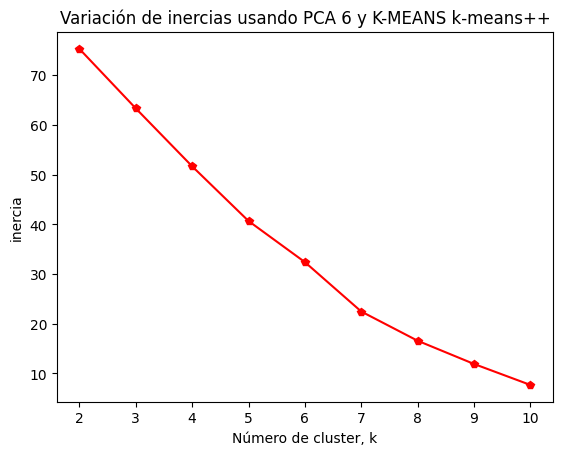

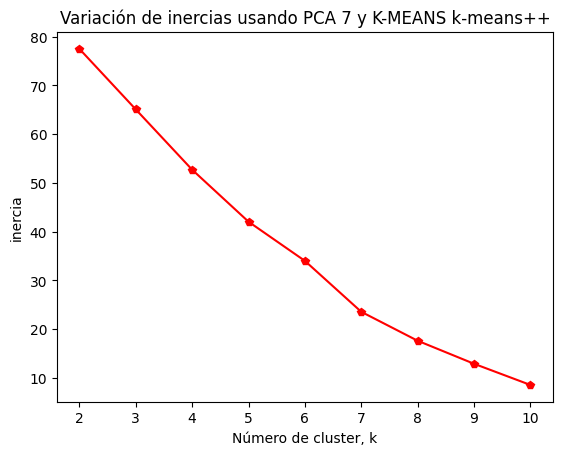

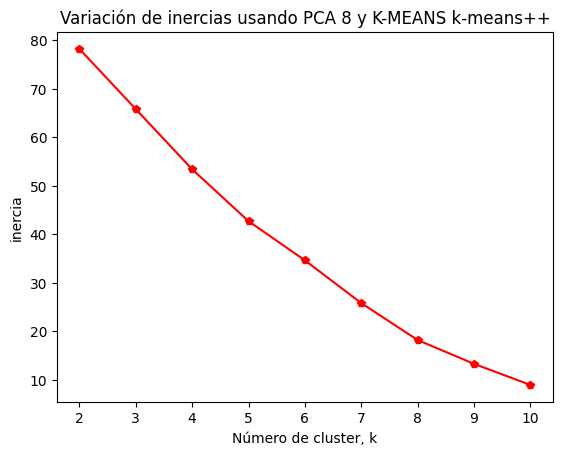

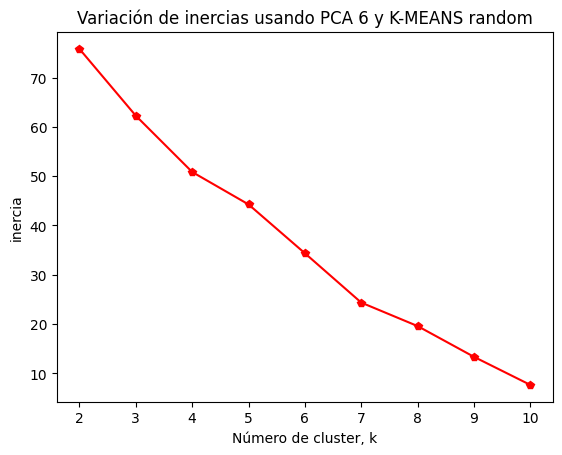

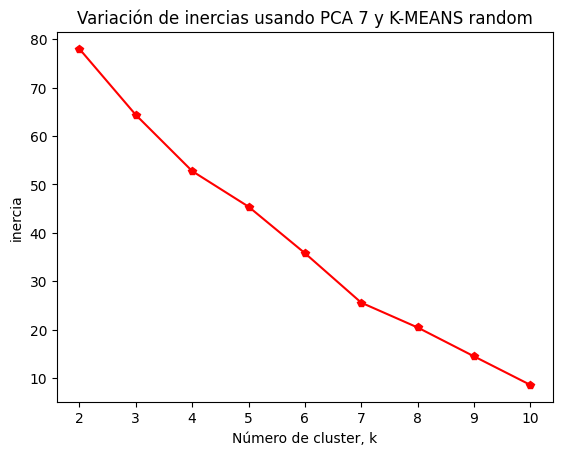

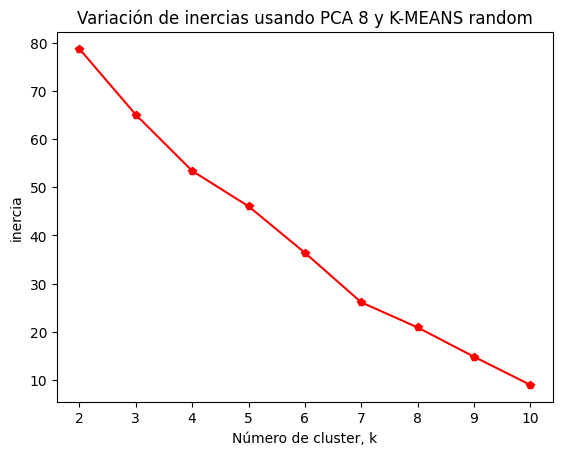

In [97]:
lst_num_features = [6,7,8]
for x_init in ['k-means++', 'random']:
  for num_features in lst_num_features:
    cluster_by_PCA(num_features, PCA_components, max_clusters = 10, kmeans_init = x_init);

### Correlación de los componentes

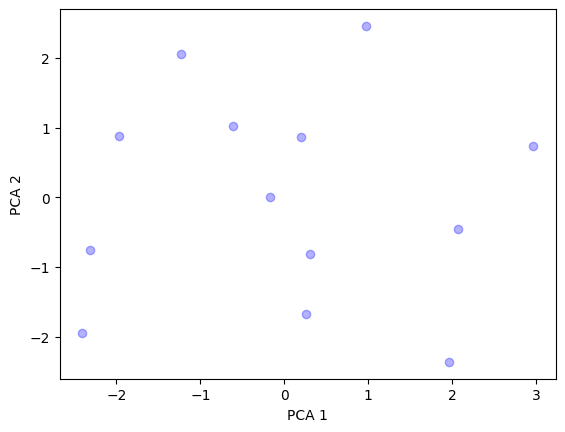

In [167]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.3, color='blue')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

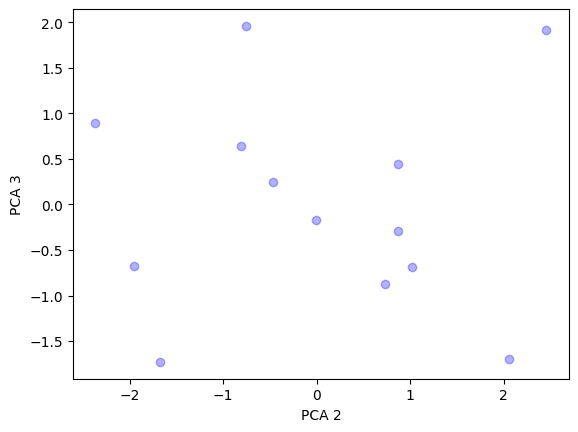

In [168]:
plt.scatter(PCA_components[1], PCA_components[2], alpha=.3, color='blue')
plt.xlabel('PCA 2')
plt.ylabel('PCA 3')
plt.show()

## Obtención de número óptimo de clusters

**NOTA**

De lo anterior se debe determinar el número de características para continuar trabajando

In [124]:
NUM_COMPONENTS_PCA = 6
IDEAL_NUMBER_CLUSTER_BY = {}

### Curva de elbow



In [137]:
def get_cluster_elbow(n_pca, max_clusters = 10, algorithm = None, kmeans_init = None):
  """
  Método curva de elbow para identificar el número óptimo de clusters
  """  
  kmeans_init= "k-means++" if kmeans_init is None else kmeans_init
  num_clusters = range(2, max_clusters+1)
  x_algorithm = "auto" if algorithm is None else algorithm
  models = [KMeans(n_clusters=i, random_state=29, algorithm=x_algorithm, init = kmeans_init) for i in num_clusters]
  score = [models[i].fit(PCA_components.iloc[:,:n_pca]).score(PCA_components.iloc[:,:n_pca]) for i in range(len(models))] 
  y_predict = [models[i].predict(PCA_components.iloc[:,:n_pca]) for i in range(len(models))]
  inercias = [models[i].inertia_ for i in range(len(models))] 

  fig, ax = plt.subplots(1, 2, figsize=(12, 6))
  ax[0].plot(num_clusters, inercias, marker='o')
  ax[0].set_title("Evolución de la varianza intra-cluster total")
  ax[0].set_xlabel('Número clusters')
  ax[0].set_ylabel('Intra-cluster (inertia)');

  ax[1].plot(num_clusters,score)
  ax[1].grid(color='r', linestyle='dotted', linewidth=1)
  ax[1].set_title("Evolución del score total")
  ax[1].set_xlabel('Número de Clusters')
  ax[1].set_ylabel('Score')

  plt.show()

Algoritmo auto


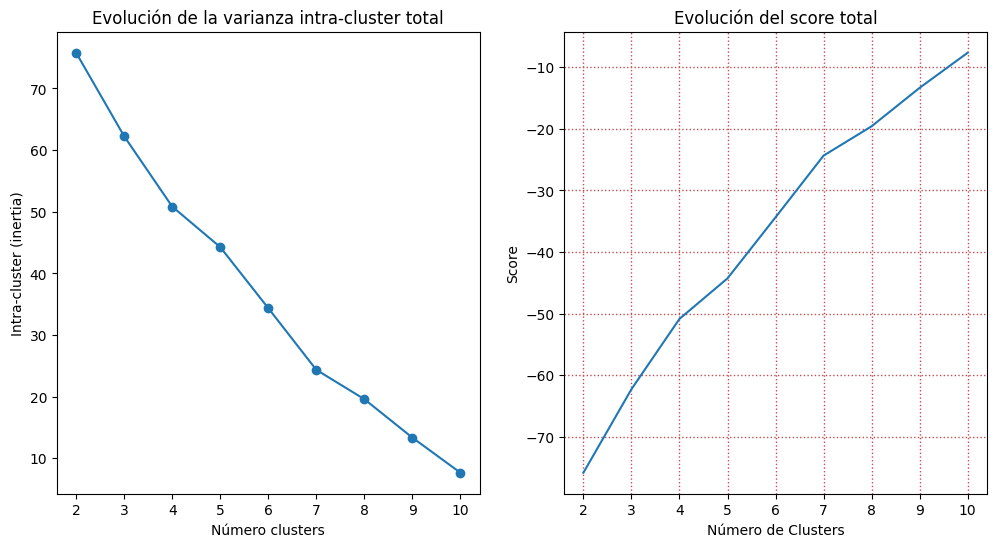

Algoritmo elkan


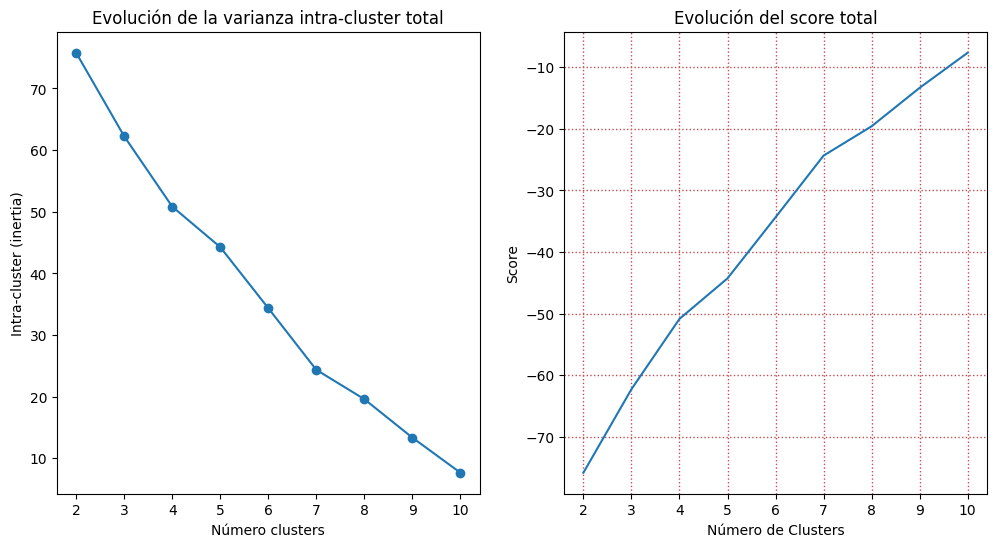

In [138]:
for alg in ['auto', 'elkan']:
  print("Algoritmo {}".format(alg))
  get_cluster_elbow(NUM_COMPONENTS_PCA,algorithm=alg, kmeans_init='random')

In [174]:
IDEAL_NUMBER_CLUSTER_BY['elbow'] = 3

### Método silhouette

In [102]:
def get_cluster_silhoutte(n_pca, max_clusters = 10, algorithm = None, kmeans_init = None):
  """
  Método silhouette para identificar el número óptimo de clusters
  """
  range_n_clusters = range(2, max_clusters+1)
  valores_medios_silhouette = []
  kmeans_init = "k-means++" if kmeans_init is None else kmeans_init
  x_algorithm = "auto" if algorithm is None else algorithm
  for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        random_state = 29, 
                        algorithm = x_algorithm, init = kmeans_init
                    )
    cluster_labels = modelo_kmeans.fit_predict(PCA_components.iloc[:,:n_pca])
    silhouette_avg = silhouette_score(PCA_components.iloc[:,:n_pca], cluster_labels, metric="sqeuclidean")
    valores_medios_silhouette.append(silhouette_avg)
  return list(range(2,max_clusters+1))[np.argmax(valores_medios_silhouette)], valores_medios_silhouette, range_n_clusters

def graphic_view(range_clusters, values, algorithm):
  fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
  ax.plot(range_clusters, values, marker='o')
  ax.set_title("Evolución de media de los índices silhouette con {}".format(algorithm))
  ax.set_xlabel('Número clusters')
  ax.set_ylabel('Media índices silhouette');


Cluster ideal, usando índices silhouette con algoritmo auto es 2
Cluster ideal, usando índices silhouette con algoritmo elkan es 2


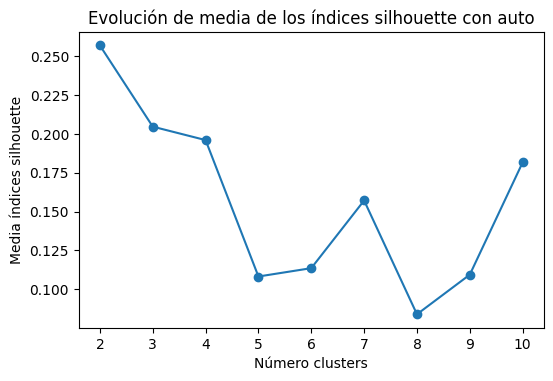

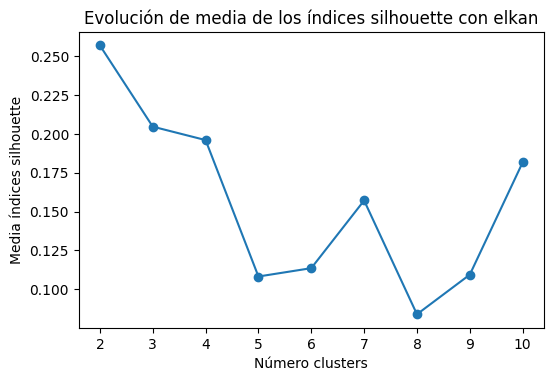

In [125]:
for alg in ['auto', 'elkan']:
  ideal_number, values, rc = get_cluster_silhoutte(NUM_COMPONENTS_PCA, kmeans_init= 'random')
  print("Cluster ideal, usando índices silhouette con algoritmo {0} es {1}".format(alg, ideal_number))
  graphic_view(rc, values, alg)
IDEAL_NUMBER_CLUSTER_BY['silhoutte'] = ideal_number

### Estadístico de GAP

In [120]:
def get_cluster_GAP(data, nrefs=3, maxClusters=10, kmeans_init = None):
    """
    Calculates KMeans optimal K using Gap Statistic 
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    kmeans_init = "k-means++" if kmeans_init is None else kmeans_init
    gaps = np.zeros((len(range(2, maxClusters+1)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(2, maxClusters+1)):
      # Holder for reference dispersion results
      refDisps = np.zeros(nrefs)
      # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
      for i in range(nrefs):      
        # Create new random reference set
        randomReference = np.random.random_sample(size=data.shape)
        # Fit to it
        km = KMeans(k, init = kmeans_init, random_state=29)
        km.fit(randomReference)
        refDisp = km.inertia_
        refDisps[i] = refDisp
        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_
        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
    return (gaps.argmax() + 1, resultsdf, resultsdf.clusterCount[gaps.argmax()])


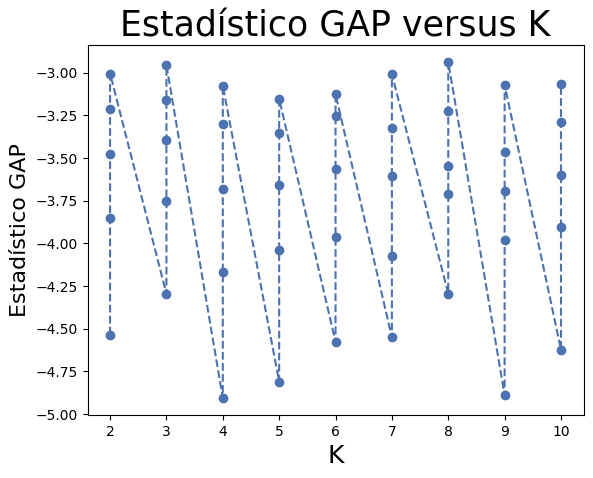

In [126]:
score_g, df, ideal_cluster_GAP = get_cluster_GAP(PCA_components.iloc[:,:NUM_COMPONENTS_PCA], nrefs=5, maxClusters=10, kmeans_init='random')
plt.plot(df['clusterCount'], df['gap'], linestyle='--', marker='o', color='b');
plt.xlabel('K', fontsize=18);
plt.ylabel('Estadístico GAP', fontsize=16);
plt.title('Estadístico GAP versus K', fontsize=25);
IDEAL_NUMBER_CLUSTER_BY['gap'] = ideal_cluster_GAP

In [175]:
IDEAL_NUMBER_CLUSTER_BY

{'elbow': 3, 'gap': 3.0, 'silhoutte': 2}

**NOTA**

Ahora que ya se tiene el número de cluster se completa el trabajo

## Generación del modelo

In [232]:
NUM_COMPONENTS_PCA = 6
NUM_CLUSTERS = 3
NUM_CLUSTERS_ALT = 2
dict_summary = {'official' :{}, 'alternative' : {}} 

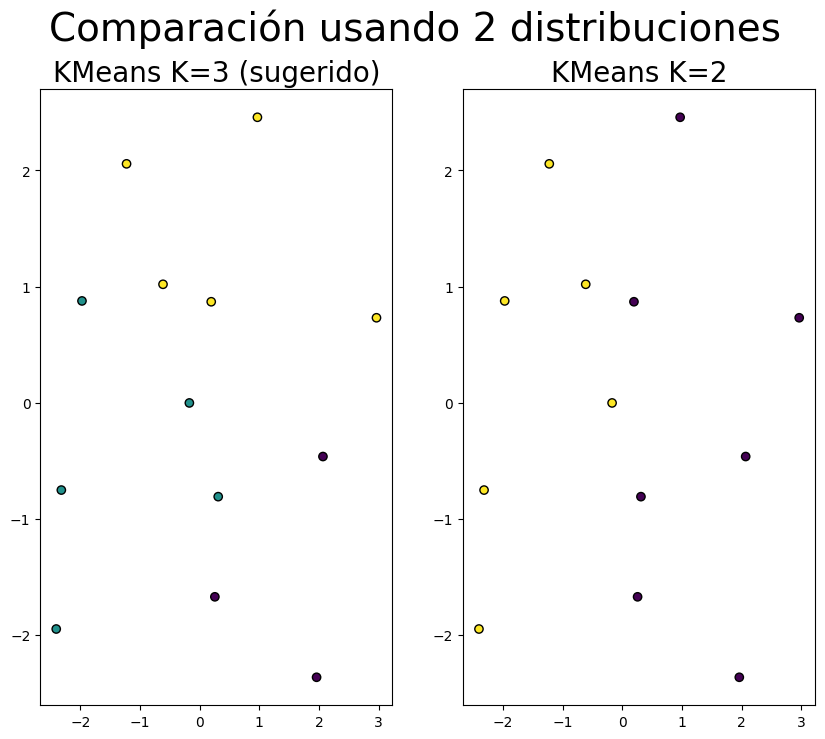

In [236]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
x_algorithm = 'auto'
kmeans_init = 'random'
# Resultados para K = valor ideal de acuerdo a los métodos anteriores
# ==============================================================================
modelo_kmeans = KMeans(n_clusters = NUM_CLUSTERS, random_state=29, init=kmeans_init,
                       algorithm = x_algorithm).fit(X=PCA_components.iloc[:,:NUM_COMPONENTS_PCA])
y_predict_a = modelo_kmeans.predict(PCA_components.iloc[:,:NUM_COMPONENTS_PCA])
dict_summary['official']['inertia'] = modelo_kmeans.inertia_
dict_summary['official']['n_features_in'] = modelo_kmeans.n_features_in_
dict_summary['official']['init'] = modelo_kmeans.init
dict_summary['official']['clusters'] = modelo_kmeans.n_clusters
dict_summary['official']['model'] = modelo_kmeans
ax[0].scatter(
        x = PCA_components[0],
        y = PCA_components[1], 
        c = y_predict_a,
        marker    = 'o',
        edgecolor = 'black'
    )
ax[0].set_title('KMeans K={} (sugerido)'.format(NUM_CLUSTERS), fontsize=20);

# Resultados para K = una unidad más de la propuesta ideal
# ==============================================================================

modelo_kmeans_alt = KMeans(n_clusters=NUM_CLUSTERS_ALT, random_state=29, init=kmeans_init,
                     algorithm = x_algorithm).fit(X=PCA_components.iloc[:,:NUM_COMPONENTS_PCA])
y_predict_b = modelo_kmeans_alt.predict(X=PCA_components.iloc[:,:NUM_COMPONENTS_PCA])
dict_summary['alternative']['inertia'] = modelo_kmeans_alt.inertia_
dict_summary['alternative']['n_features_in'] = modelo_kmeans_alt.n_features_in_
dict_summary['alternative']['init'] = modelo_kmeans_alt.init
dict_summary['alternative']['clusters'] = modelo_kmeans_alt.n_clusters
dict_summary['alternative']['model'] = modelo_kmeans_alt
ax[1].scatter(
        x = PCA_components[0],
        y = PCA_components[1], 
        c = y_predict_b,
        marker    = 'o',
        edgecolor = 'black'
    )
ax[1].set_title('KMeans K={}'.format(NUM_CLUSTERS_ALT), fontsize=20)
plt.suptitle("Comparación usando 2 distribuciones", fontsize=28)
plt.show()

In [237]:
pd.DataFrame(dict_summary).T

,inertia,n_features_in,init,clusters,model
official,62.253247,6,random,3,"KMeans(init='random', n_clusters=3, random_sta..."
alternative,75.801404,6,random,2,"KMeans(init='random', n_clusters=2, random_sta..."


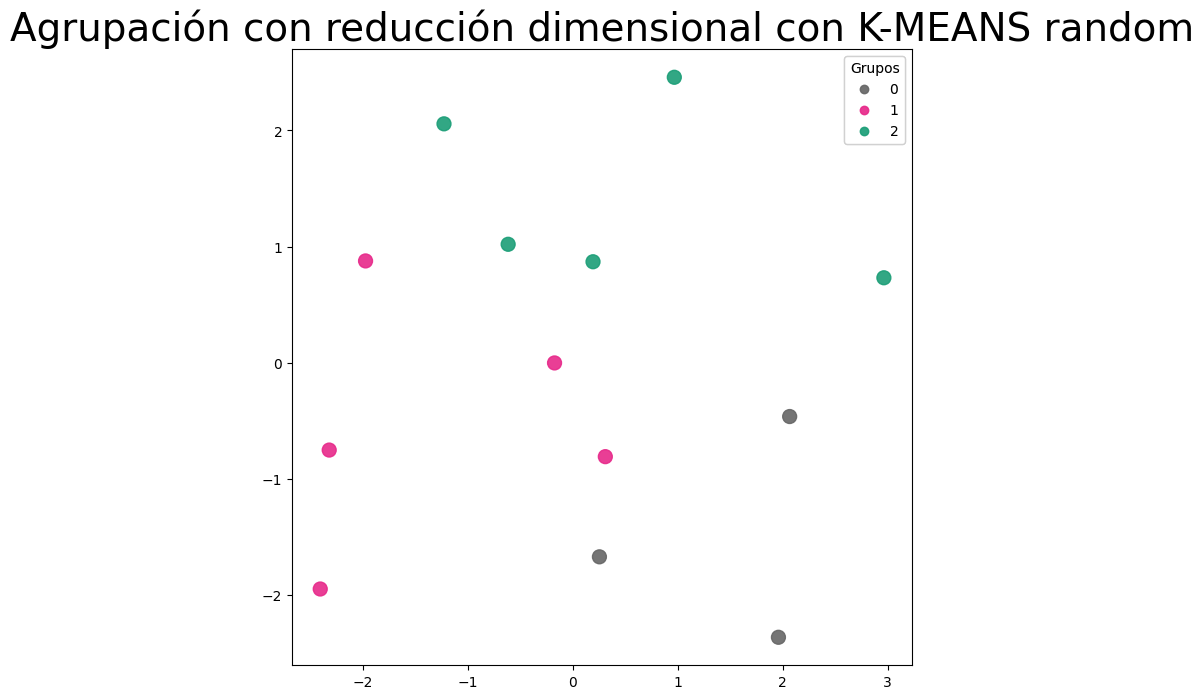

In [226]:
labels = group_by_PCA(NUM_COMPONENTS_PCA, PCA_components, NUM_CLUSTERS, kmeans_init = 'random')

In [187]:
y_predict_a == labels

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [238]:
data_final = get_data_final(data_selected, y_predict_a)
data_final

,id,i1,i2,i3,i4,i5,i6,i7,i8,puntaje,nota,categoria,prob_total,grupo,total
9,10,5.0,2.0,3.0,2.0,1.0,1.0,1.0,2.0,22.0,3.8,4,0.806650,0,1
30,31,4.0,3.0,1.0,1.0,2.0,2.0,2.0,2.0,22.0,3.8,4,0.806650,0,1
36,37,1.0,1.0,3.0,3.0,2.0,3.0,2.0,1.0,21.0,3.6,4,0.455052,1,1
43,44,5.0,1.0,3.0,4.0,1.0,2.0,1.0,1.0,23.0,3.9,4,0.912272,1,1
44,45,2.0,1.0,2.0,3.0,1.0,5.0,1.0,1.0,21.0,3.6,4,0.455052,1,1
64,65,5.0,4.0,1.0,1.0,1.0,2.0,1.0,1.0,21.0,3.6,4,0.455052,0,1
70,71,1.0,2.0,2.0,2.0,1.0,2.0,3.0,2.0,20.0,3.5,4,0.273531,2,1
77,78,1.0,2.0,1.0,1.0,4.0,3.0,3.0,1.0,21.0,3.6,4,0.455052,2,1
80,81,1.0,3.0,1.0,1.0,3.0,1.0,1.0,3.0,19.0,3.4,4,0.137542,2,1
95,96,1.0,1.0,3.0,2.0,3.0,1.0,1.0,1.0,18.0,3.2,4,0.019228,2,1


In [239]:
def view_mean_by_column(data_frame, column):
  data_frame.groupby('grupo')[column].mean().plot.bar();

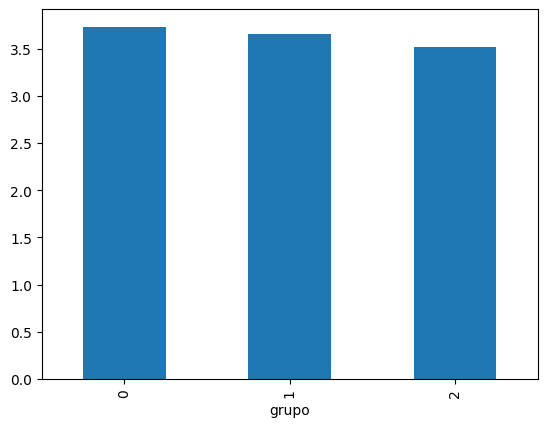

In [240]:
view_mean_by_column(data_final, 'nota')

In [241]:
pd.DataFrame(y_predict_a, columns=['grupo']).groupby("grupo").size()

grupo
0    3
1    5
2    5
dtype: int64

## Evaluación usando el coeficiente de Silhouette

In [260]:
def evaluate_with_silhoutte(y_predict, n_clusters, n_pca):
  score = silhouette_score(PCA_components.iloc[:,:n_pca], y_predict, metric="sqeuclidean")
  print(f"Silhouette Coefficient: {score:.3f} with{n_clusters:3d} clusters")
  score = silhouette_score(PCA_components.iloc[:,:n_pca], y_predict)
  print(f"Silhouette Coefficient (metric -> euclidian): {score:.3f} with{n_clusters:3d} clusters")

In [263]:
evaluate_with_silhoutte(y_predict_b, NUM_CLUSTERS_ALT, NUM_COMPONENTS_PCA)
print("*"*50)
evaluate_with_silhoutte(y_predict_a, NUM_CLUSTERS, NUM_COMPONENTS_PCA)

Silhouette Coefficient: 0.257 with  2 clusters
Silhouette Coefficient (metric -> euclidian): 0.145 with  2 clusters
**************************************************
Silhouette Coefficient: 0.205 with  3 clusters
Silhouette Coefficient (metric -> euclidian): 0.115 with  3 clusters


The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

## Comparación de modelos

In [264]:
def display_variants(n_max_clusters, kmeans_init = None):
  range_n_clusters = range(2, n_max_clusters+1)
  kmeans_init = 'k-means++' if kmeans_init is None else kmeans_init
  for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(PCA_components.iloc[:,:NUM_COMPONENTS_PCA]) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init = kmeans_init, random_state=29)
    cluster_labels = clusterer.fit_predict(PCA_components.iloc[:,:NUM_COMPONENTS_PCA])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(PCA_components.iloc[:,:NUM_COMPONENTS_PCA], cluster_labels, 
                                      metric="sqeuclidean")
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(PCA_components.iloc[:,:NUM_COMPONENTS_PCA], cluster_labels, 
                                                  metric="sqeuclidean")

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        PCA_components[0], PCA_components[1], marker=".", s=30, lw=0, alpha=0.7, 
        c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

  plt.show()

For n_clusters = 2 The average silhouette_score is : 0.2569024446487146
For n_clusters = 3 The average silhouette_score is : 0.20464290809452068
For n_clusters = 4 The average silhouette_score is : 0.19598729230691395
For n_clusters = 5 The average silhouette_score is : 0.10815253837470841
For n_clusters = 6 The average silhouette_score is : 0.11352669814387058
For n_clusters = 7 The average silhouette_score is : 0.15709445906472355
For n_clusters = 8 The average silhouette_score is : 0.08382584695433695
For n_clusters = 9 The average silhouette_score is : 0.10933694546645271
For n_clusters = 10 The average silhouette_score is : 0.1816014497036014


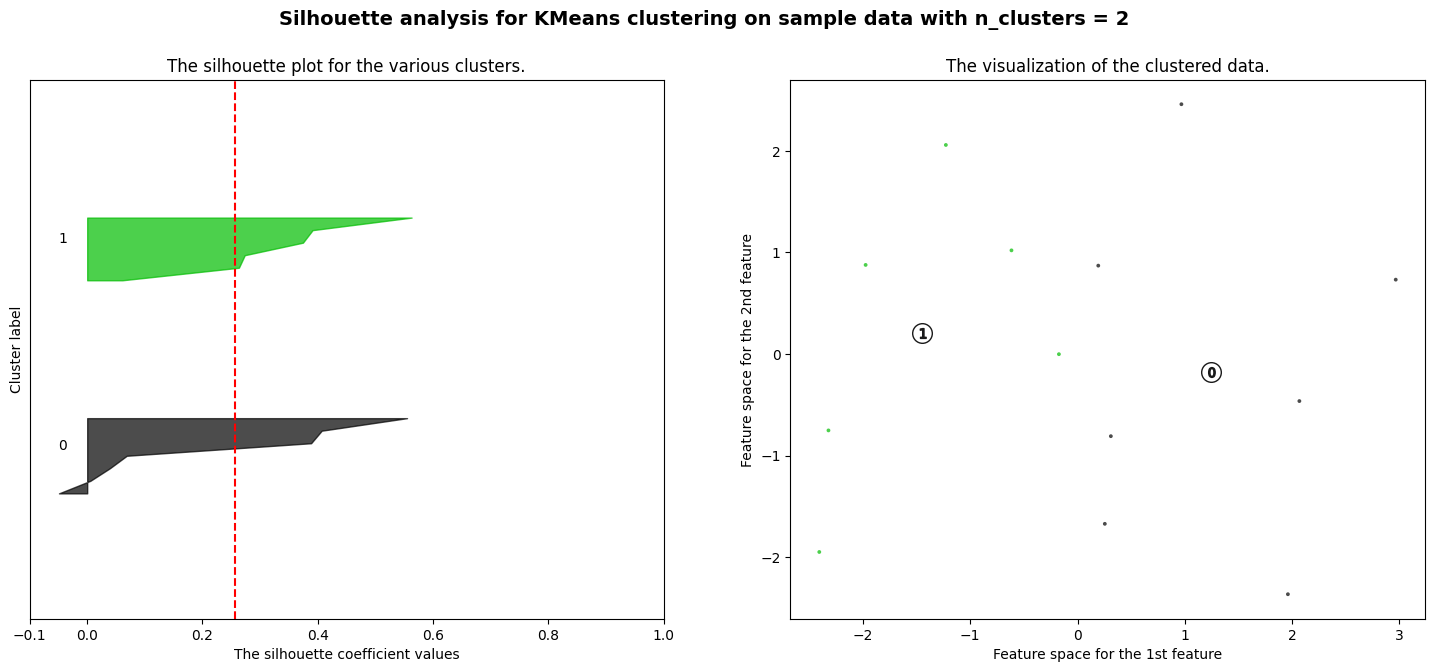

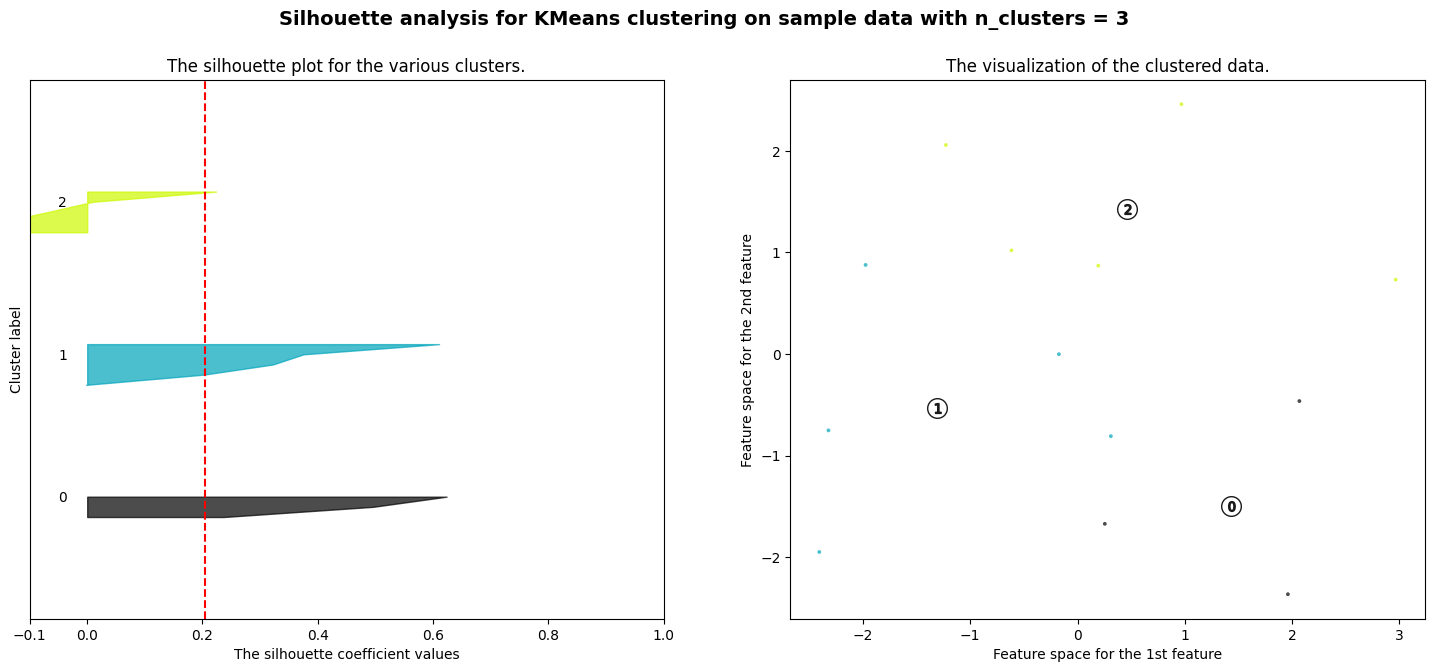

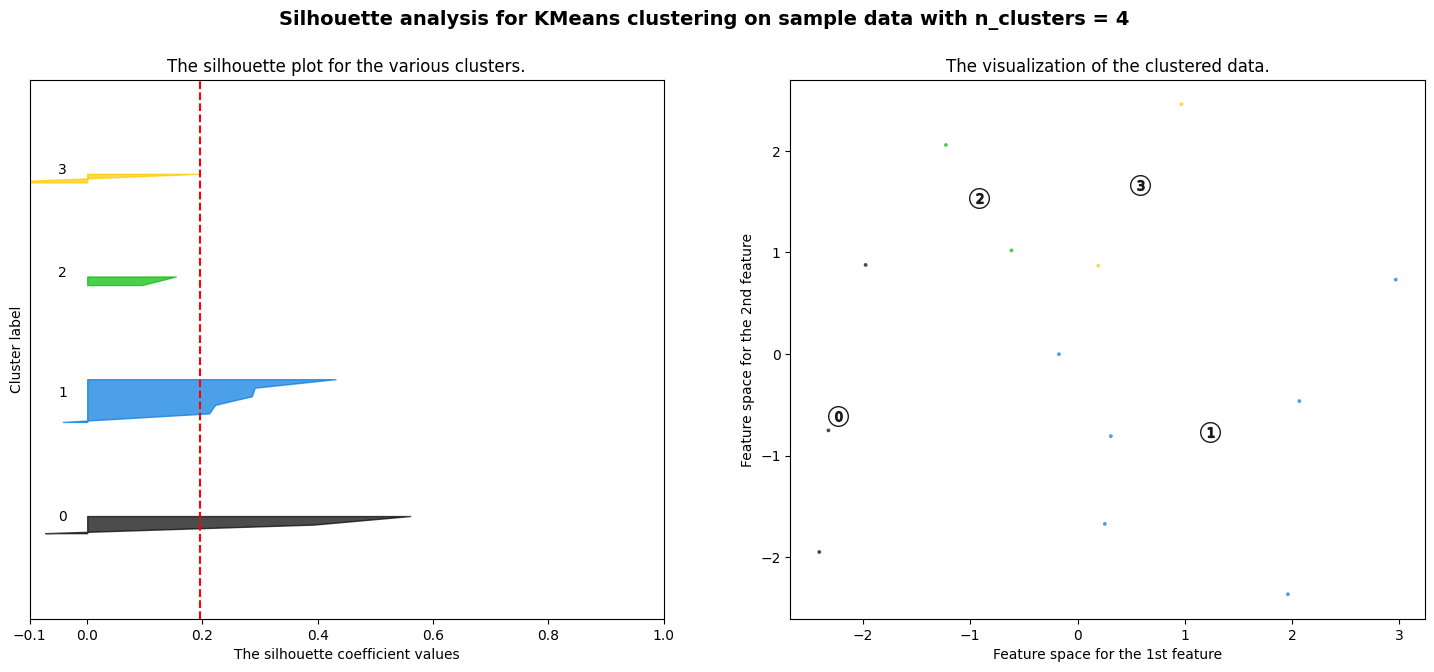

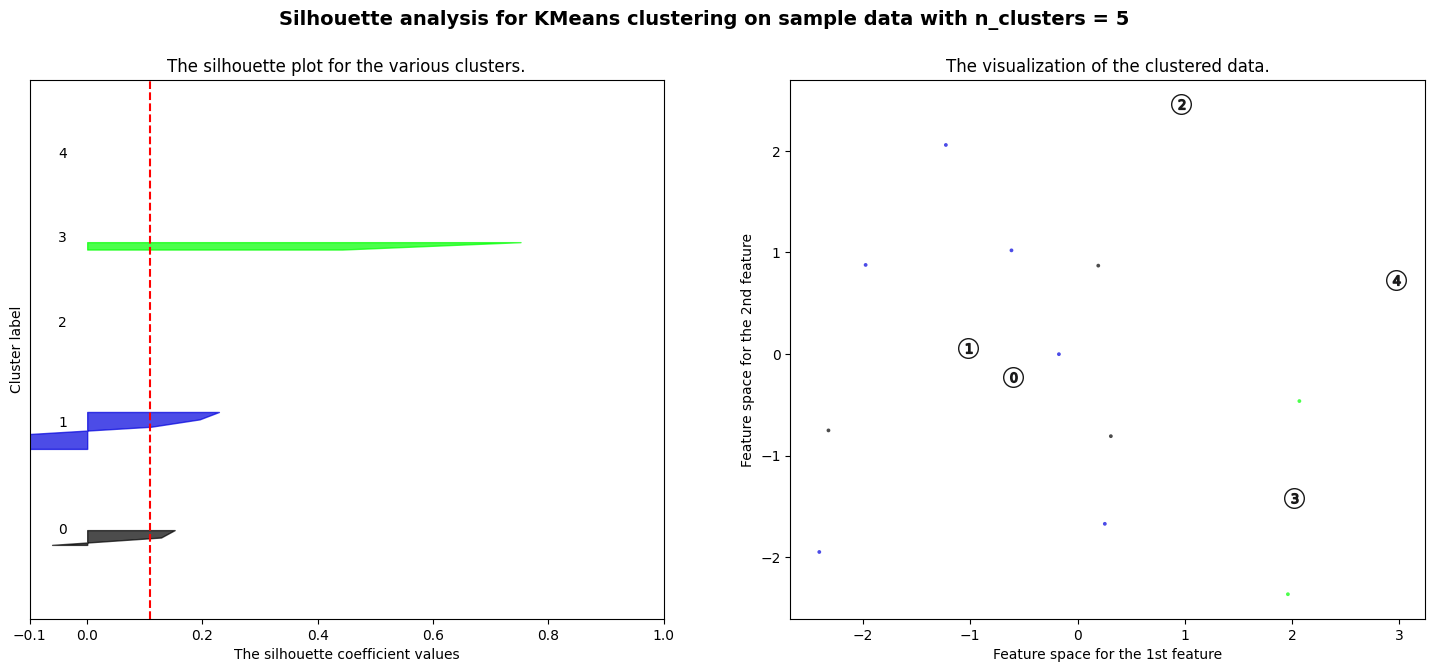

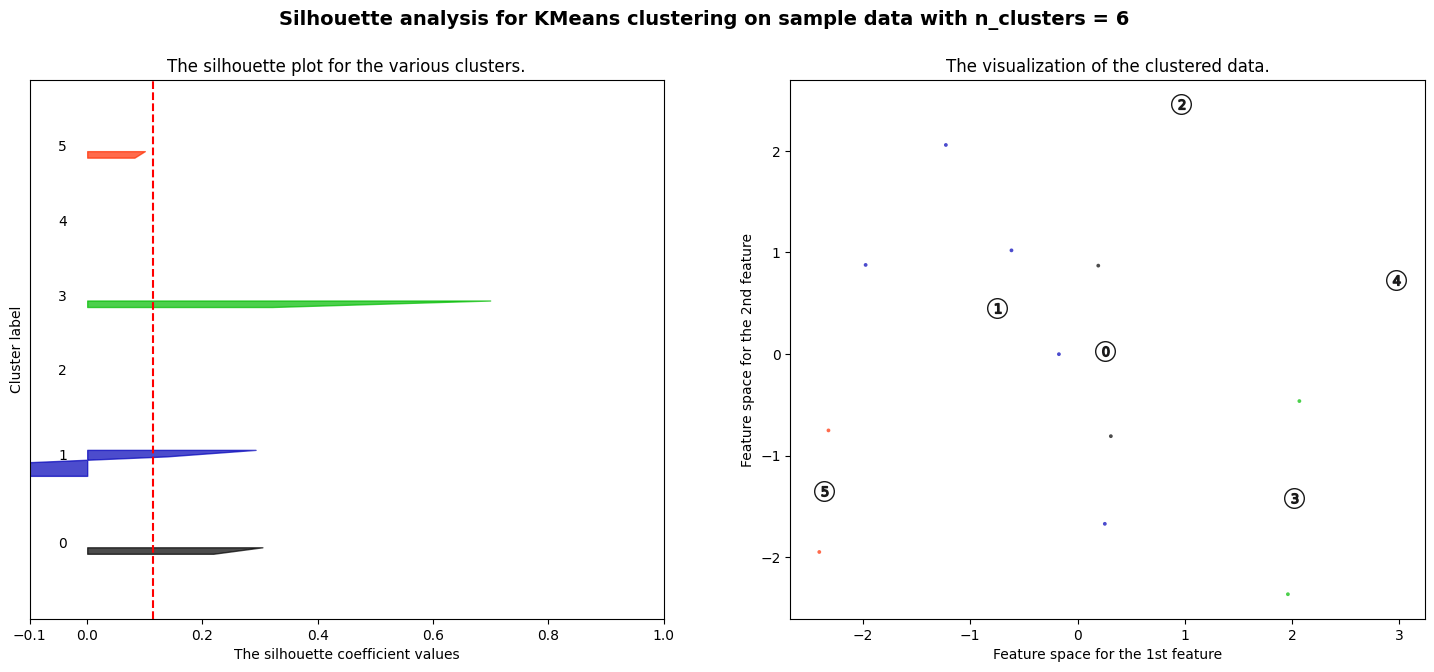

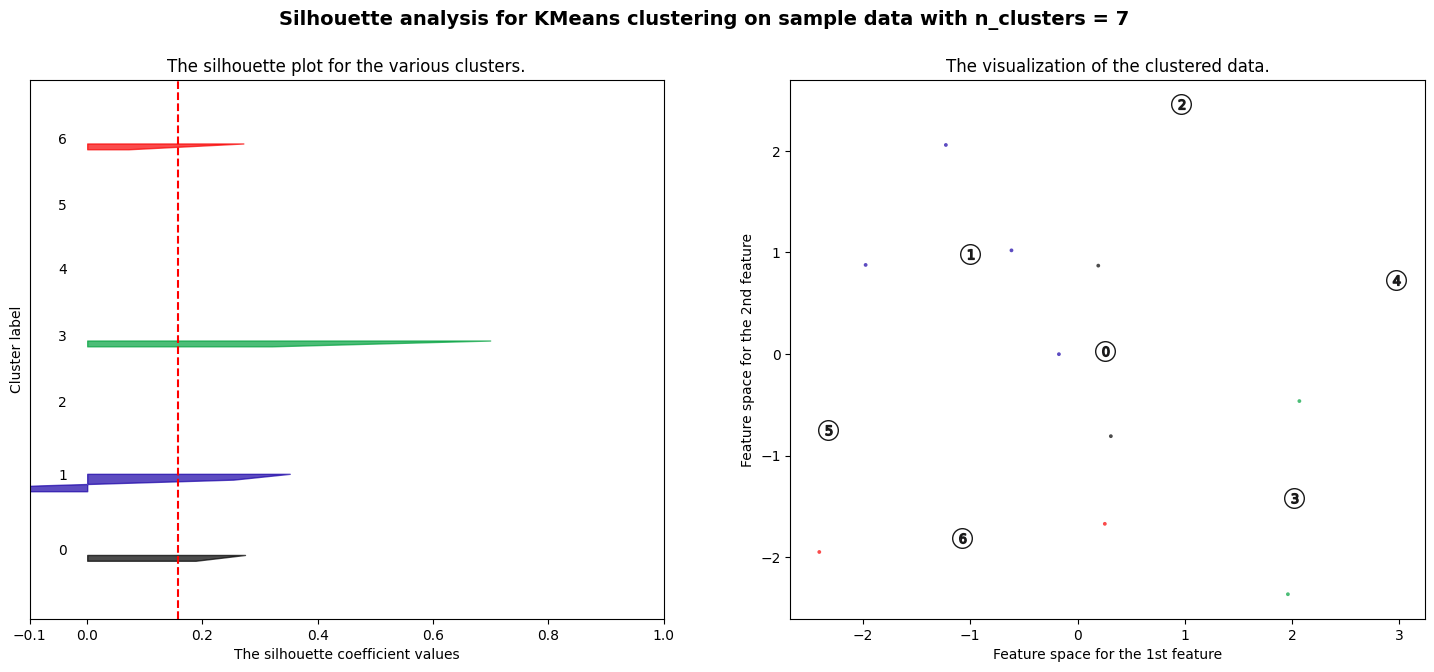

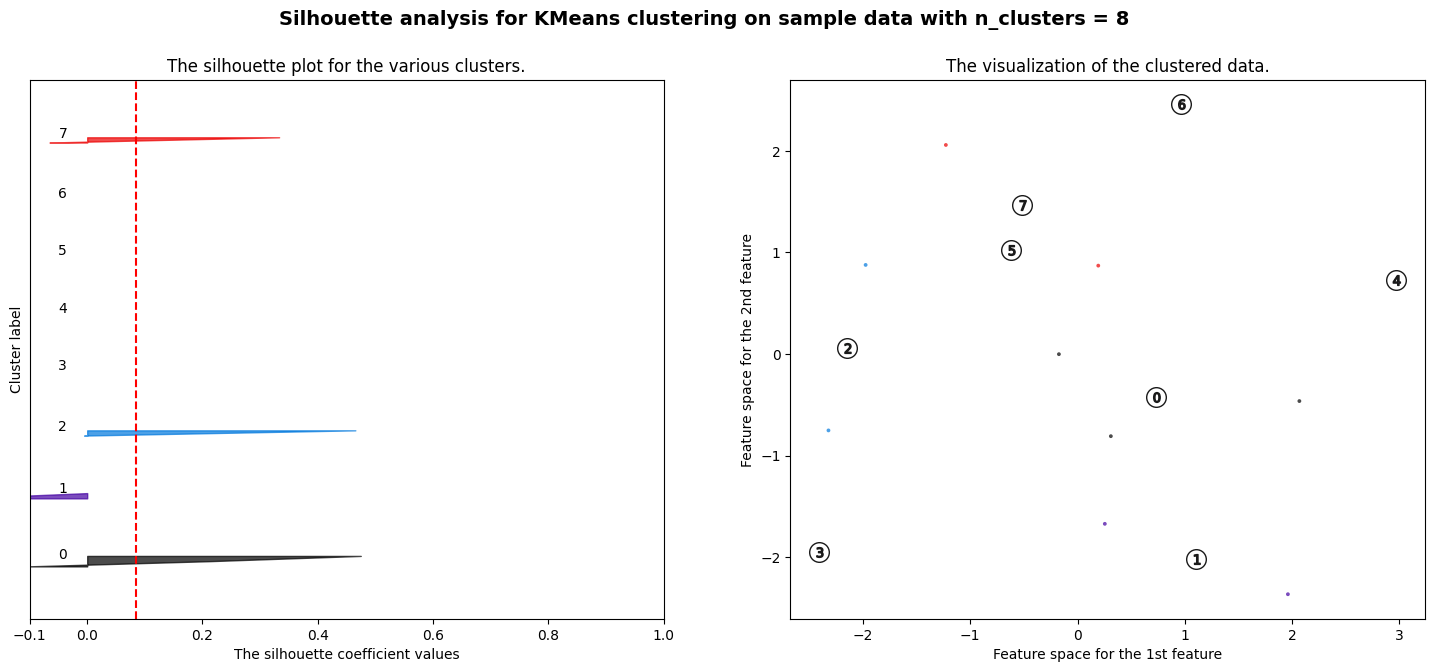

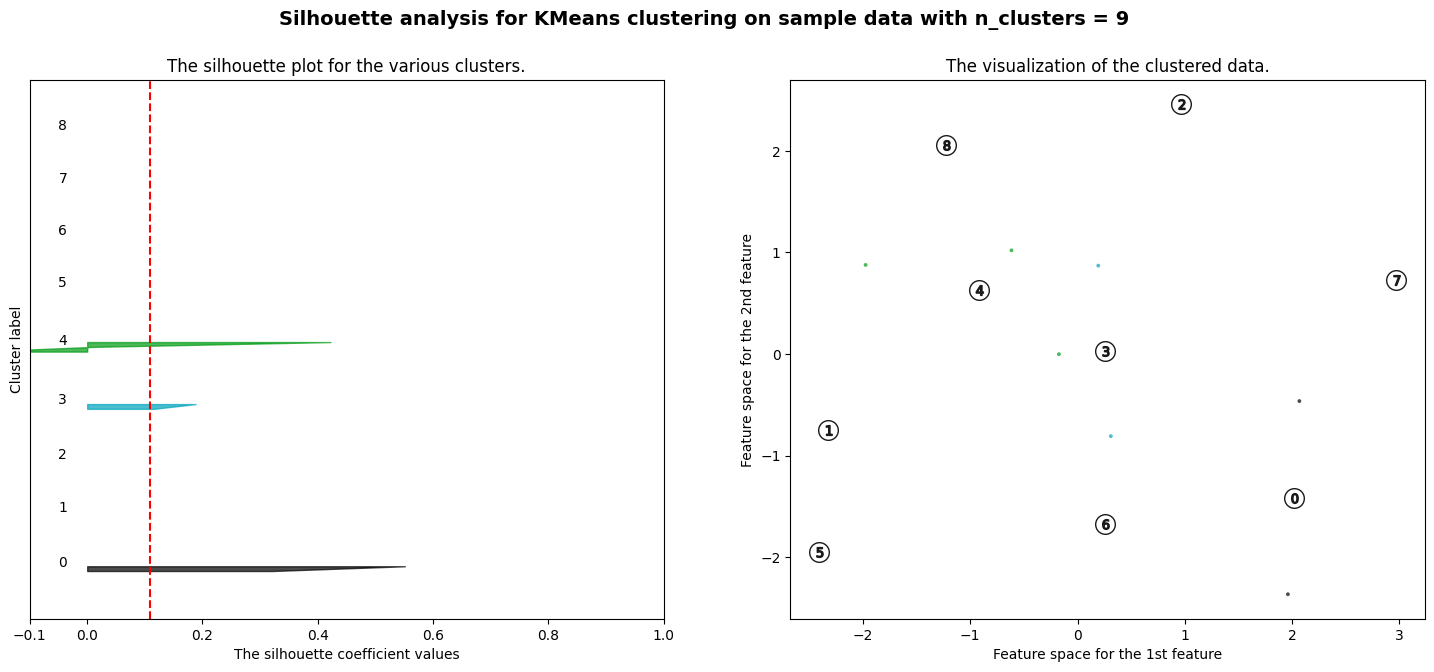

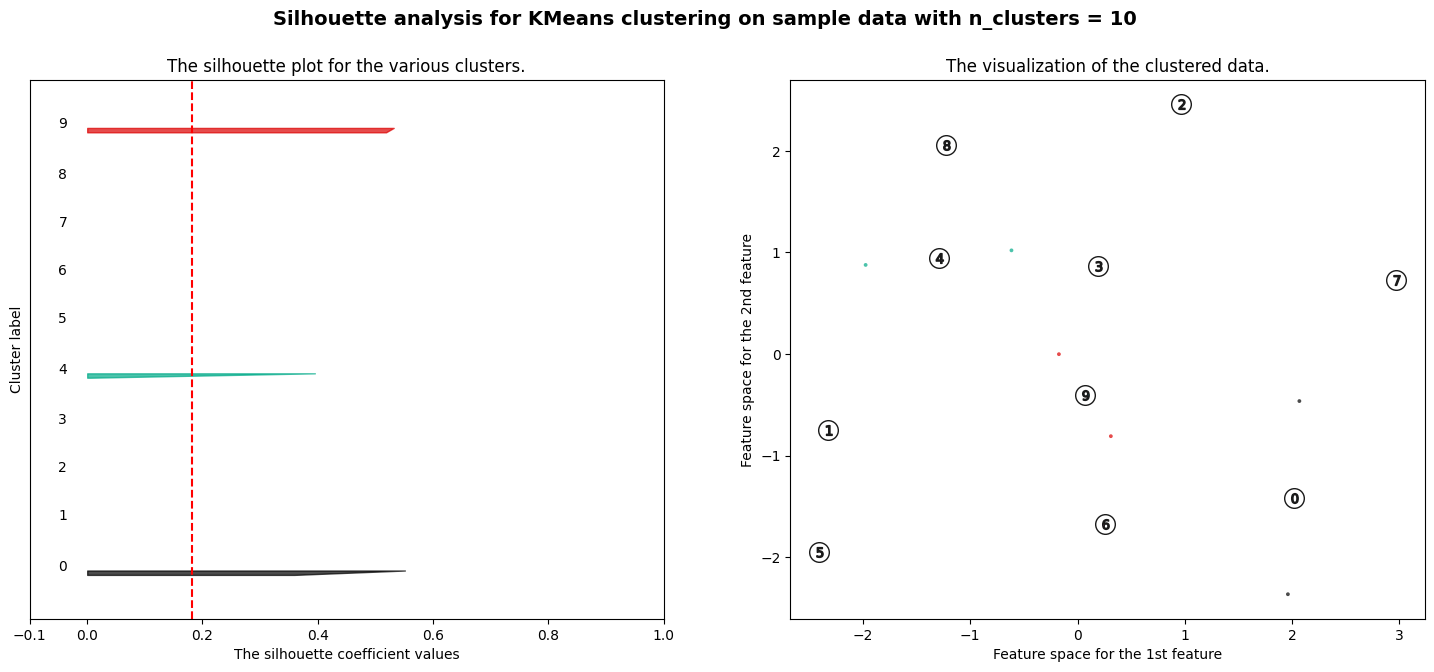

In [265]:
display_variants(10, 'random')

## Análisis de clusters

### Funciones

In [164]:
def get_data_final(data, y_predict):
  data_final = data.copy()
  data_final['grupo'] = y_predict
  data_final['total'] = 1
  return data_final

def get_selected_features(data, features_selected = ['id', 'grupo', 'nota']):
  return data[features_selected]

def get_clusters(data):
  return data['grupo'].unique()

def get_total_by_cluster(data):
  return data.groupby('grupo')[['total']].sum()  

def get_metrics_by_cluster(data, columns, metrics):
  return data.groupby('grupo')[columns].aggregate(metrics)

def get_summary_cluster(data, cluster, selected):
  return data[data.grupo == cluster][selected]    

### Obtener grupos

In [165]:
data_final_x = get_data_final(data_selected, y_predict_a)
data_final_y = get_data_final(data_selected, y_predict_b)

### Ver resultados

In [53]:
get_selected_features(data_final_x)

,id,grupo,nota
9,10,0,3.8
30,31,0,3.8
36,37,1,3.6
43,44,1,3.9
44,45,1,3.6
64,65,0,3.6
70,71,1,3.5
77,78,1,3.6
80,81,0,3.4
95,96,1,3.2


In [54]:
print(get_clusters(data_final_x))
print(get_clusters(data_final_y))

[0 1]
[0 1 2]


In [55]:
lst_features_selected = ['id', 'grupo']
df_merge = pd.merge(data_final_x[lst_features_selected], data_final_y[lst_features_selected], how='inner', on='id')
df_merge['equals'] = df_merge.apply(lambda x : x.grupo_x == x.grupo_y, axis=1)
df_merge

,id,grupo_x,grupo_y,equals
0,10,0,0,True
1,31,0,1,False
2,37,1,0,False
3,44,1,2,False
4,45,1,2,False
5,65,0,1,False
6,71,1,0,False
7,78,1,1,True
8,81,0,1,False
9,96,1,0,False


In [56]:
get_total_by_cluster(data_final_x)

,total
grupo,
0,5
1,8


In [57]:
get_total_by_cluster(data_final_y)

,total
grupo,
0,7
1,4
2,2


In [58]:
lst_metrics = [np.mean, np.median, np.max, np.min]
get_metrics_by_cluster(data_final_x, lst_include, lst_metrics)

i1                      i2         ...   i7          i8                 
       mean median amax amin   mean median  ... amax amin   mean median amax amin
grupo                                       ...                                  
0      3.40    4.0  5.0  1.0  2.800    3.0  ...  2.0  1.0  2.000    2.0  3.0  1.0
1      1.75    1.0  5.0  1.0  1.375    1.0  ...  3.0  1.0  1.375    1.0  2.0  1.0

[2 rows x 32 columns]

In [59]:
lst_features = ['puntaje', 'nota']
get_metrics_by_cluster(data_final_x, lst_features, lst_metrics)

puntaje                       nota                 
         mean median  amax  amin    mean median amax amin
grupo                                                    
0      20.600   21.0  22.0  19.0  3.6000    3.6  3.8  3.4
1      21.125   21.0  23.0  18.0  3.6375    3.6  3.9  3.2

In [60]:
df_pivot = data_final_x.pivot_table(values='nota', index='grupo',  aggfunc = [np.median, np.mean, np.min, np.max])
df_pivot

,median,mean,amin,amax
,nota,nota,nota,nota
grupo,,,,
0,3.6,3.6000,3.4,3.8
1,3.6,3.6375,3.2,3.9


In [61]:
df_pivot = df_pivot.unstack().reset_index()
df_pivot.columns = ['metric','feature','group','value']
df_pivot

,metric,feature,group,value
0,median,nota,0,3.6000
1,median,nota,1,3.6000
2,mean,nota,0,3.6000
3,mean,nota,1,3.6375
4,amin,nota,0,3.4000
5,amin,nota,1,3.2000
6,amax,nota,0,3.8000
7,amax,nota,1,3.9000


In [62]:
for grupo in data_final_x.grupo.unique():
  print("-"*50)
  print("Resumen grupo {}".format(grupo))
  print("-"*50)
  print(get_summary_cluster(data_final_x, grupo, selected))

--------------------------------------------------
Resumen grupo 0
--------------------------------------------------
      i1   i2   i3   i4   i5   i6   i7   i8  nota  puntaje
9    5.0  2.0  3.0  2.0  1.0  1.0  1.0  2.0   3.8     22.0
30   4.0  3.0  1.0  1.0  2.0  2.0  2.0  2.0   3.8     22.0
64   5.0  4.0  1.0  1.0  1.0  2.0  1.0  1.0   3.6     21.0
80   1.0  3.0  1.0  1.0  3.0  1.0  1.0  3.0   3.4     19.0
139  2.0  2.0  1.0  2.0  1.0  3.0  1.0  2.0   3.4     19.0
--------------------------------------------------
Resumen grupo 1
--------------------------------------------------
      i1   i2   i3   i4   i5   i6   i7   i8  nota  puntaje
36   1.0  1.0  3.0  3.0  2.0  3.0  2.0  1.0   3.6     21.0
43   5.0  1.0  3.0  4.0  1.0  2.0  1.0  1.0   3.9     23.0
44   2.0  1.0  2.0  3.0  1.0  5.0  1.0  1.0   3.6     21.0
70   1.0  2.0  2.0  2.0  1.0  2.0  3.0  2.0   3.5     20.0
77   1.0  2.0  1.0  1.0  4.0  3.0  3.0  1.0   3.6     21.0
95   1.0  1.0  3.0  2.0  3.0  1.0  1.0  1.0   3.2     18

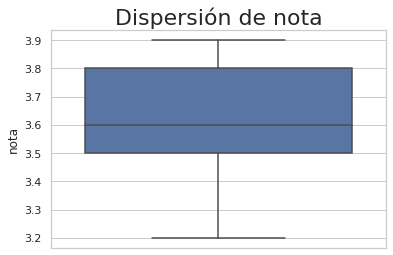

In [63]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(y='nota', data= data_final_x)
ax.set_title("Dispersión de nota", fontsize=22);

In [64]:
data_final_x.nota.describe()

count    13.000000
mean      3.623077
std       0.212736
min       3.200000
25%       3.500000
50%       3.600000
75%       3.800000
max       3.900000
Name: nota, dtype: float64

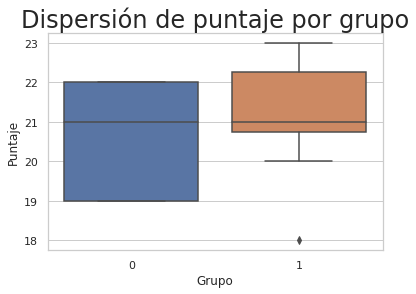

In [65]:
ax = sns.boxplot(x="grupo", y="puntaje", data=data_final_x)
ax.set_xlabel("Grupo")
ax.set_ylabel("Puntaje")
ax.set_title("Dispersión de puntaje por grupo", fontsize=24);

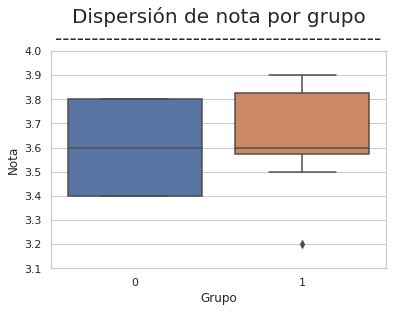

In [66]:
ax = sns.boxplot(x="grupo", y="nota", data=data_final_x)
min_value = np.min(data_final_x.nota)
ax.set_ylim(min_value-0.1,4.0)
ax.set_xlabel("Grupo")
ax.set_ylabel("Nota")
ax.set_title("Dispersión de nota por grupo\n"+"-"*45, fontsize=20);

**Interpetación**

![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Boxplot_vs_PDF.svg/598px-Boxplot_vs_PDF.svg.png)

In [67]:
def get_describe_by_cluster(data, cluster, selected):
  return data[data.grupo == cluster][selected].describe()

In [68]:
for cluster in np.sort(get_clusters(data_final_x)):
  print("-"*50)
  print("Summary cluster {}".format(cluster))
  print("-"*50)
  print(get_describe_by_cluster(data_final_y, cluster, ['nota', 'puntaje']))

--------------------------------------------------
Summary cluster 0
--------------------------------------------------
           nota    puntaje
count  7.000000   7.000000
mean   3.600000  20.714286
std    0.251661   1.799471
min    3.200000  18.000000
25%    3.450000  19.500000
50%    3.600000  21.000000
75%    3.800000  22.000000
max    3.900000  23.000000
--------------------------------------------------
Summary cluster 1
--------------------------------------------------
           nota    puntaje
count  4.000000   4.000000
mean   3.600000  20.750000
std    0.163299   1.258306
min    3.400000  19.000000
25%    3.550000  20.500000
50%    3.600000  21.000000
75%    3.650000  21.250000
max    3.800000  22.000000


## Guarda resultados

In [ ]:
for n_grupo in data_final_x.grupo.unique():
  data_final_x[data_final_x.grupo == n_grupo][['id','nota']].to_csv("Grupo_{}.csv".format(n_grupo), index=False)

In [ ]:
for n_grupo in data_final_y.grupo.unique():
  data_final_y[data_final_y.grupo == n_grupo][['id','nota']].to_csv("Grupo_{}_B.csv".format(n_grupo), index=False)

## Más visualizaciones

### Diagrama de violin

Un diagrama de violín se utiliza para visualizar la distribución de los datos y su densidad de probabilidad.

Este gráfico es una combinación de un diagrama de cajas y bigotes y un diagrama de densidad girado y colocado a cada lado, para mostrar la forma de distribución de los datos. La barra negra gruesa en el centro representa el intervalo intercuartil, la barra negra fina que se extiende desde ella, representa el 95 % de los intervalos de confianza, y el punto blanco es la mediana.

Los diagramas de cajas y bigotes están limitados a su visualización de los datos, ya que su simplicidad visual tiende a ocultar detalles significativos sobre cómo se distribuyen los valores en los datos. Por ejemplo, con los diagramas de cajas y bigotes no puedes ver si la distribución es bimodal o multimodal. Si bien los diagramas de violín incluyen más información, pueden estar mucho más abarrotados que los diagramas de cajas y bigotes.

![](https://datavizcatalogue.com/ES/metodos/images/anatomy/SVG/diagrama_de_violin.svg)

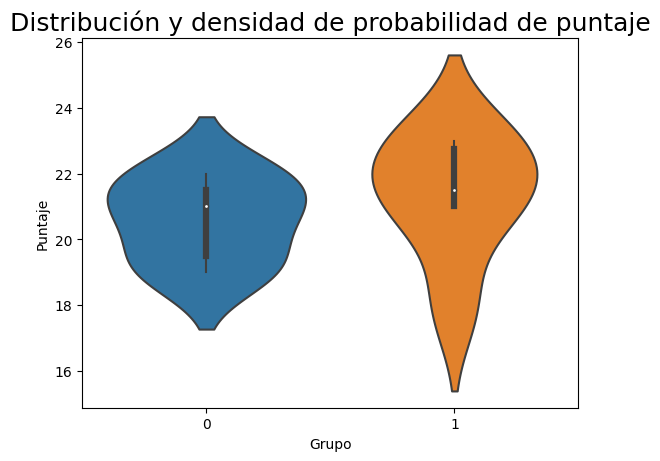

In [193]:
ax=sns.violinplot(x="grupo", y="puntaje", data=data_final_x)
ax.set_title("Distribución y densidad de probabilidad de puntaje", fontsize=18)
ax.set_xlabel("Grupo")
ax.set_ylabel("Puntaje");

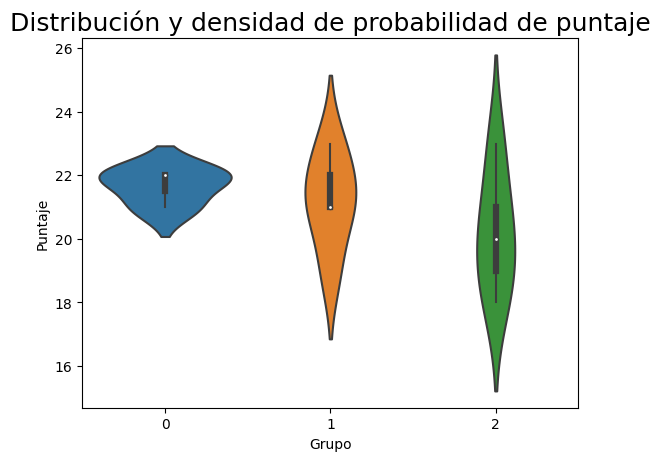

In [167]:
ax=sns.violinplot(x="grupo", y="puntaje", data=data_final_y)
ax.set_title("Distribución y densidad de probabilidad de puntaje", fontsize=18)
ax.set_xlabel("Grupo")
ax.set_ylabel("Puntaje");

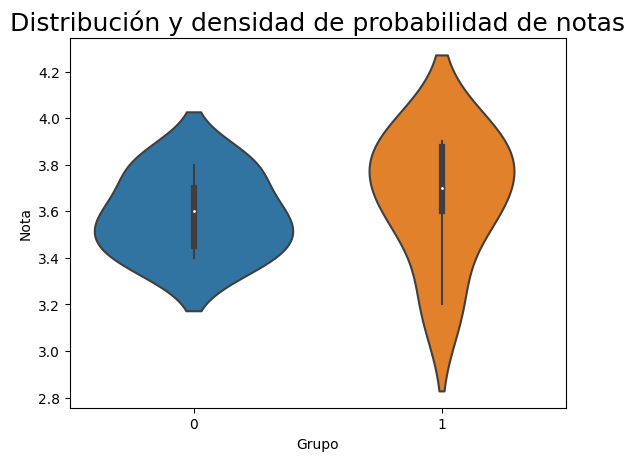

In [168]:
ax = sns.violinplot(x="grupo", y="nota", data=data_final_x)
ax.set_title("Distribución y densidad de probabilidad de notas", fontsize=18)
ax.set_xlabel("Grupo")
ax.set_ylabel("Nota");

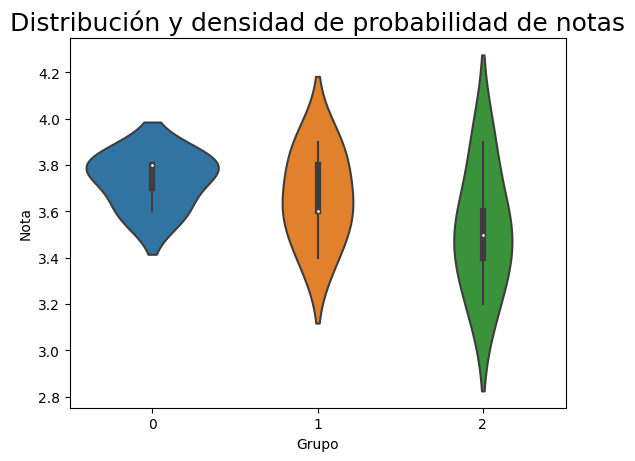

In [169]:
ax = sns.violinplot(x="grupo", y="nota", data=data_final_y)
ax.set_title("Distribución y densidad de probabilidad de notas", fontsize=18)
ax.set_xlabel("Grupo")
ax.set_ylabel("Nota");

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1ddaaf58-075e-4191-8bbb-dc9543aea97c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>